# [SKT Market Top AI]Transformer‑based Multivariate Time Series Anomaly Detection using Inter‑Variable Attention Mechanism

## 요약

- 변수 간의 시간적 종속성과 관계를 명시적으로 캡처하는 다변량 시계열 이상 탐지 방법인 `Variable Temporal Transformer`를 제안

- 시간 종속성을 학습하는 Temporal self-attention과 변수 간 상관관계를 명시적으로 캡처하기 위해 기존의 Temporal self-attention을 수정하여 새로 제안된 `Variable self-attention`을 도입

- 4개의 공개 benchmark 데이터셋에 대해 VTT가 baseline보다 개선된 성능을 보임

- 원본 데이터에서 추출한 attention map과 재구성된 데이터에서 추출한 attention map을 비교하여 이상치 발생 원인을 추정하는 프로세스를 제안

<img src="../image/VTT_architecture.png" width="600">

[Kang, Hyeongwon, and Pilsung Kang. "Transformer-based multivariate time series anomaly detection using inter-variable attention mechanism." Knowledge-Based Systems (2024): 111507.](https://www.sciencedirect.com/science/article/pii/S0950705124001424?ref=pdf_download&fr=RR-2&rr=88e52cc379d63158)

### SETP 0. 환경 구축하기

---

- VTT 모델에 맞는 환경을 구축하기 위하여 필요한 패키지를 설치합니다.

In [1]:
# github에서 데이터 불러오기
# !git clone https://github.com/hwk0702/KBS2024-VTT.git
# %cd ./KBS2024-VTT/src
%cd ../src

# !pip install -r ../requirements.txt|

/home/iai3/Desktop/Bongjun/RTM/drystrip_4차/VTT_entire_wafer/src


- 필요한 library들을 import 합니다.

In [2]:
import os  # 운영 체제와의 상호작용을 위한 모듈
import sys  # 시스템 특정 파라미터와 함수를 위한 모듈
import random  # 난수 생성기를 위한 모듈
import math  # 수학적 함수와 상수를 위한 모듈
import time  # 시간 관련 함수를 위한 모듈
import json  # JSON 데이터 파싱과 생성을 위한 모듈
import yaml  # YAML 파일 파싱과 생성을 위한 모듈
import warnings  # 경고 메시지를 관리하기 위한 모듈
warnings.filterwarnings("ignore")  # 경고 메시지를 무시하도록 설정

import argparse  # 명령행 옵션, 인자 파싱 모듈
from datetime import datetime  # 날짜와 시간 관련 모듈

import numpy as np # 다차원 배열과 연산을 다루는 모듈
import pandas as pd  # 데이터 조작 및 분석을 위한 라이브러리
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # 데이터 전처리를 위한 스케일링 모듈

import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리
# %matplotlib inline  # 주피터 노트북에서 인라인으로 그래프를 표시

from easydict import EasyDict  # 딕셔너리의 속성을 점 표기법으로 접근할 수 있도록 하는 모듈
from omegaconf import OmegaConf  # 설정 파일 관리를 위한 모듈

import torch  # 딥러닝을 위한 라이브러리
from torch import optim, einsum  # 최적화 및 다차원 배열 연산을 위한 모듈
import torch.nn as nn  # 신경망 구축을 위한 모듈
from torch.utils.data import Dataset  # 데이터셋 구성을 위한 모듈
from torch.nn.utils import weight_norm  # 신경망 가중치 정규화를 위한 모듈

from einops import rearrange, repeat  # 배열 재구성 및 반복을 위한 모듈

from layers.Transformer_Enc import PreNorm, FeedForward  # 사용자 정의 트랜스포머 인코더 모듈

from utils.utils import set_seed, log_setting, version_build  # 유틸리티 함수들
from utils.tools import EarlyStopping, adjust_learning_rate, check_graph  # 학습 조기 종료 및 학습률 조정 도구
from data_provider.waferdataset import get_dataloader  # 데이터 로더 함수
from model import build_model  # 모델 빌드 함수

# torch 버전 및 디바이스를 확인
print("Python version:[%s]." % (sys.version))
print("PyTorch version:[%s]." % (torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:[%s]." % (device))  # GPU를 사용 가능한 경우 'cuda:0'가 출력되면 GPU를 사용

Python version:[3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]].
PyTorch version:[2.7.0+cu118].
device:[cuda:0].


모델에 필요한 argument들을 설정합니다.

In [3]:
# 설정 인자들을 정의
args = EasyDict({
    # for dataloader 
    'dataname': 'vtt_step45_big_ref',
    'subdataname': None,
    'window_size': 30,
    'slide_size': 1,

    # for training
    'train': True,
    'test': True,
    'resume': None,
    'model': 'VTTSAT',
    'epochs': 20,
    'patience': 5,

    # for loss
    'loss': 'mse',

    # for setting
    'seed': 72,
    'use_gpu':True,
    'gpu': 0,
    'use_multi_gpu': False,
    'devices': '0',
    'configure': './config.yaml',
    'batch_size': 16
})

# 구성 파일을 로드합니다.
with open(args.configure) as f:
    config = OmegaConf.load(f)

# 로드된 구성 내용을 출력합니다.
print(OmegaConf.to_yaml(config, resolve=True))

path: ./
log_dir: ./logs
workers: 8
GDN_step45_100_ref:
  train_dir: ../../data/GDN_step45_100_ref/train
  test_dir: ../../data/GDN_step45_100_ref/test
GDN_step45_100_ref_val:
  train_dir: ../../data/GDN_step45_100_ref_val/train
  val_dir: ../../data/GDN_step45_100_ref_val/val
  test_dir: ../../data/GDN_step45_100_ref_val/test
GDN_step45_big_ref:
  train_dir: ../../data/GDN_step45_big_ref/train
  test_dir: ../../data/GDN_step45_big_ref/test
GDN_step45_big_ref_val:
  train_dir: ../../data/GDN_step45_big_ref_val/train
  val_dir: ../../data/GDN_step45_big_ref_val/val
  test_dir: ../../data/GDN_step45_big_ref_val/test
vtt_step45_big_ref:
  train_dir: ../../data/vtt_step45_big_ref/train
  test_dir: ../../data/vtt_step45_big_ref/test
SMD:
  train_dir: ../data/ServerMachineDataset/train
  test_dir: ../data/ServerMachineDataset/test
  test_label_dir: ../data/ServerMachineDataset/test_label
  interpretation_label_dir: ../data/ServerMachineDataset/interpretation_label
scale: standard
loader_para

In [4]:
# 로그 디렉토리와 저장 디렉토리를 설정
logdir = os.path.join(config.log_dir, f'{args.dataname}/{args.model}')
savedir = version_build(logdir=logdir, is_train=args.train, resume=args.resume)

# GPU 사용 설정을 구성
if args.use_gpu and args.use_multi_gpu:
    # GPU 디바이스 목록을 설정
    args.devices = args.devices.replace(' ', '')
    args.device_ids = list(map(int, args.devices.split(',')))
    args.gpu = args.device_ids[0]  # 첫 번째 GPU를 기본 GPU로 설정

# 랜덤 시드를 설정
set_seed(args.seed)

# 모델 파라미터를 설정
model_params = config[args.model]

# # 모델 파라미터를 수정(실험 세팅 가볍게)
# model_params.n_layer = 1
# model_params.n_head = 2

### SETP 1. 데이터 준비하기 (이 부분만 데이터를 포맷에 맞게 코드 변경 해주시면 됩니다!)

SWaT 데이터를 활용하여 시계열 이상탐지를 진행합니다.
* 스마트 물 처리 공장 내의 센서 및 액추에이터 데이터로, 펌프와 밸브 등의 작동 상태를 바탕으로 추출된 물의 흐름, 압력, 수위 등 다양한 물리적 변수 포함
* 11일 간 51개 센서에서 수집된 데이터셋이며, 다양한 사이버 공격 시나리오가 포함됨. 이상치는 전체 11일 기간 중 마지막 4일에서 총 41회 발생
* 데이터 크기 및 유형: 11일간의 연속 데이터, 946,722개의 데이터 포인트, 이상 비율 11.98%
* 데이터셋 출처
    * https://itrust.sutd.edu.sg/itrust-labs_datasets/dataset_info/

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from tqdm import tqdm
import os
import h5py

"""
GDN에 적합하도록 WaferDataset을 변환한 데이터셋 클래스
dataset_preprocessing.ipynb에서 생성하여, h5 파일 이용
"""
class WaferDataset(Dataset):
    def __init__(self, file_list, model_type='reconstruction'):
        self.file_list = file_list
        self.model_type = model_type

        all_data, all_next_steps, all_labels = [], [], []
        self.lotids = []
        self.wafer_numbers = []
        self.step_nums = []

        for file_path in tqdm(file_list, desc="Loading and merging data"):
            with h5py.File(file_path, 'r') as f:
                all_data.append(f['data'][:].astype(float))
                all_next_steps.append(f['next_step'][:].astype(float))
                all_labels.append(f['labels'][:])

                self.lotids.extend(f['lotids'][:].astype(str))
                self.wafer_numbers.extend(f['wafer_numbers'][:].astype(str))
                self.step_nums.extend(f['step_num'][:])

        self.all_data = np.concatenate(all_data, axis=0)
        self.all_next_steps = np.concatenate(all_next_steps, axis=0)
        self.all_labels = np.concatenate(all_labels, axis=0)
        self.n_sensor = self.all_data.shape[2]

    def __len__(self):
        return self.all_data.shape[0]

    def __getitem__(self, idx):
        window_data = self.all_data[idx] # (window_size, n_features)
        y = self.all_next_steps[idx]
        label = self.all_labels[idx]
        lotid = self.lotids[idx]
        wafer_number = self.wafer_numbers[idx]
        step_num = int(self.step_nums[idx])
        
        item = {
            'given': window_data,
            'lotid': lotid,
            'wafer_number': wafer_number,
            'step_num': step_num
        }
        
        if self.model_type == 'reconstruction':
            # item["ts"] = self.ts[i:last]
            item["answer"] = window_data
            # if self.with_attack:
            #     item['attack'] = self.attacks[i:last]
        elif self.model_type == 'prediction':
            # item["ts"] = self.ts[last]
            item["answer"] = y
            # if self.with_attack:
            #     item['attack'] = self.attacks[last]
        return item

def get_dataloader(data_info, loader_params: dict):
    """
    GDN 모델에 적합한 DataLoader 생성 함수 (train/val split 포함)

    Args:
        data_info (dict): 'train_dir' 키 포함
        loader_params (dict): batch_size, use_val 등 포함

    Returns:
        tuple: (train_loader, val_loader or None, test_loader)
    """
    # 전체 train 파일 리스트
    train_files = sorted([
        os.path.join(data_info['train_dir'], f)
        for f in os.listdir(data_info['train_dir'])
        if f.endswith(".h5")
    ])

    # validation 포함 여부
    if loader_params['use_val']:
        val_files = sorted([
        os.path.join(data_info['val_dir'], f)
        for f in os.listdir(data_info['val_dir'])
        if f.endswith(".h5")
    ])

        val_dataset = WaferDataset(val_files)
        val_loader = DataLoader(val_dataset,
                                batch_size=loader_params['batch_size'],
                                shuffle=False,
                                num_workers=0,
                                pin_memory=True,
                                drop_last=False)
    else:
        val_loader = None

    # test 파일 리스트 (필요시 별도 dir로 교체 가능)
    test_files = sorted([
        os.path.join(data_info['test_dir'], f)
        for f in os.listdir(data_info['test_dir'])
        if f.endswith(".h5")
    ])

    # Dataset & DataLoader
    train_dataset = WaferDataset(train_files)
    test_dataset = WaferDataset(test_files)

    train_loader = DataLoader(train_dataset,
                              batch_size=loader_params['batch_size'],
                              shuffle=True,
                              num_workers=0,
                              pin_memory=True,
                              drop_last=False)

    test_loader = DataLoader(test_dataset,
                             batch_size=loader_params['batch_size']*4,
                             shuffle=False,
                             num_workers=0,
                             pin_memory=True,
                             drop_last=False)

    return train_loader, val_loader, test_loader


### STEP 4. 데이터로더 생성

<img src="../image/Split_window.png" width="800">

In [84]:

data_info = config[args.dataname]

trainloader, validloader, testloader = get_dataloader(data_info = data_info,
                                                        loader_params = config['loader_params'])        


Loading and merging data: 100%|██████████| 16808/16808 [00:21<00:00, 771.28it/s]


### STEP 5. VTT

<img src="../image/VTT_architecture.png" width="700">

#### Embedding

<img src="../image/embedding.png" width="800">

In [3]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]
    
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, groups=1):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=padding,
            dilation=dilation,
            groups=groups
        )

    def forward(self, x):
        out = self.conv(x)
        out = out[:, :, : -self.conv.padding[0]]
        return out

#### Attention

<img src="../image/Transformer_layer.png" width="700">

In [4]:
class VariableAttention(nn.Module):
    def __init__(
            self,
            dim,
            heads=8,
            dim_head=16,
            dropout=0.
    ):
        super().__init__()
        inner_dim = dim_head * heads # 각 헤드의 차원 수 곱
        self.heads = heads
        self.scale = dim_head ** -0.5 # 스케일링 인자 (어텐션 점수 안정화)

        # Query, Key, Value를 위한 선형 변환
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

        # 드롭아웃 레이어
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, use_attn):
        b, t, f, d = x.shape
        x = rearrange(x, 'b t f d -> (b t) f d') # [batch, time, features, dim] -> [(batch * time), features, dim]
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim=-1) # Query, Key, Value 분리
        q, k, v = map(lambda m: rearrange(m, 'b n (h d) -> b h n d', h=h), (q, k, v)) # [batch, features, (heads * dim)] -> [batch, heads, features, dim]
        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale # 어텐션 점수 계산

        attn = sim.softmax(dim=-1) # 어텐션 점수 소프트맥스
        weights = attn if use_attn else None # 어텐션 가중치 반환 여부
        attn = self.dropout(attn) # 드롭아웃 적용

        out = einsum('b h i j, b h j d -> b h i d', attn, v) # Value와 어텐션 가중치로 가중합
        out = rearrange(out, 'b h n d -> b n (h d)', h=h) # [batch, heads, features, dim] -> [batch, features, (heads * dim)]
        out = self.to_out(out) # 출력 레이어 통과
        out = rearrange(out, '(b t) f d -> b t f d', t=t) # [(batch * time), features, dim] -> [batch, time, features, dim]
        return out, weights
    
class TemporalAttention(nn.Module):
    def __init__(
            self,
            dim,
            heads=8,
            dim_head=16,
            dropout=0.
    ):
        super().__init__()
        inner_dim = dim_head * heads  # 각 헤드의 차원 수 곱
        self.heads = heads
        self.scale = dim_head ** -0.5  # 스케일링 인자 (어텐션 점수 안정화)

        # Query, Key, Value를 위한 선형 변환 레이어
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

        # 드롭아웃 레이어
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, use_attn):
        b, t, f, d = x.shape
        x = rearrange(x, 'b t f d -> (b f) t d')  # [batch, time, features, dim] -> [(batch * features), time, dim]
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim=-1)  # Query, Key, Value 분리
        q, k, v = map(lambda m: rearrange(m, 'b n (h d) -> b h n d', h=h), (q, k, v))  # [batch, time, (heads * dim)] -> [batch, heads, time, dim]
        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale  # 어텐션 점수 계산

        attn = sim.softmax(dim=-1)  # 어텐션 점수 소프트맥스
        weights = attn if use_attn else None  # 어텐션 가중치 반환 여부
        attn = self.dropout(attn)  # 드롭아웃 적용

        out = einsum('b h i j, b h j d -> b h i d', attn, v)  # Value와 어텐션 가중치로 가중합
        out = rearrange(out, 'b h n d -> b n (h d)', h=h)  # [batch, heads, time, dim] -> [batch, time, (heads * dim)]
        out = self.to_out(out)  # 출력 레이어 통과
        out = rearrange(out, '(b f) t d -> b t f d', f=f)  # [(batch * features), time, dim] -> [batch, time, features, dim]
        return out, weights


class VariableTemporalAttention(nn.Module):
    def __init__(
            self,
            dim,
            heads=8,
            dim_head=16,
            dropout=0.
    ):
        super().__init__()
        inner_dim = dim_head * heads  # 각 헤드의 차원 수 곱
        self.heads = heads
        self.scale = dim_head ** -0.5  # 스케일링 인자 (어텐션 점수 안정화)

        # Variable Attention
        self.variable_to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.variable_to_out = nn.Linear(inner_dim, dim)
        self.variable_dropout = nn.Dropout(dropout)

        # Temporal Attention
        self.temporal_to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.temporal_to_out = nn.Linear(inner_dim, dim)
        self.temporal_dropout = nn.Dropout(dropout)

        # 결합된 출력에 대한 선형 변환
        self.linear = nn.Linear(dim * 2, dim)

    def forward(self, x, use_attn):
        b, t, f, d = x.shape

        # Variable Attention
        vx = rearrange(x, 'b t f d -> (b t) f d')  # [batch, time, features, dim] -> [(batch * time), features, dim]
        h = self.heads
        vq, vk, vv = self.variable_to_qkv(vx).chunk(3, dim=-1)  # Query, Key, Value 분리
        vq, vk, vv = map(lambda m: rearrange(m, 'b n (h d) -> b h n d', h=h), (vq, vk, vv))  # [batch, features, (heads * dim)] -> [batch, heads, features, depth]
        sim = einsum('b h i d, b h j d -> b h i j', vq, vk) * self.scale  # 어텐션 점수 계산

        vattn = sim.softmax(dim=-1)  # 어텐션 점수 소프트맥스
        vweights = vattn if use_attn else None  # 어텐션 가중치 반환 여부
        vattn = self.variable_dropout(vattn)  # 드롭아웃 적용

        vout = einsum('b h i j, b h j d -> b h i d', vattn, vv)  # Value와 어텐션 가중치로 가중합
        vout = rearrange(vout, 'b h n d -> b n (h d)', h=h)  # [batch, heads, features, dim] -> [batch, features, (heads * dim)]
        vout = self.variable_to_out(vout)  # 출력 레이어 통과
        vout = rearrange(vout, '(b t) f d -> b t f d', t=t)  # [(batch * time), features, dim] -> [batch, time, features, dim]

        # Temporal Attention
        tx = rearrange(x, 'b t f d -> (b f) t d')  # [batch, time, features, dim] -> [(batch * features), time, dim]
        tq, tk, tv = self.temporal_to_qkv(tx).chunk(3, dim=-1)  # Query, Key, Value 분리
        tq, tk, tv = map(lambda m: rearrange(m, 'b n (h d) -> b h n d', h=h), (tq, tk, tv))  # [batch, time, (heads * dim)] -> [batch, heads, time, dim]
        sim = einsum('b h i d, b h j d -> b h i j', tq, tk) * self.scale  # 어텐션 점수 계산

        tattn = sim.softmax(dim=-1)  # 어텐션 점수 소프트맥스
        tweights = tattn if use_attn else None  # 어텐션 가중치 반환 여부
        tattn = self.temporal_dropout(tattn)  # 드롭아웃 적용

        tout = einsum('b h i j, b h j d -> b h i d', tattn, tv)  # Value와 어텐션 가중치로 가중합
        tout = rearrange(tout, 'b h n d -> b n (h d)', h=h)  # [batch, heads, time, dim] -> [batch, time, (heads * dim)]
        tout = self.temporal_to_out(tout)  # 출력 레이어 통과
        tout = rearrange(tout, '(b f) t d -> b t f d', f=f)  # [(batch * features), time, dim] -> [batch, time, features, dim]

        # 결합된 출력
        out = torch.cat([vout, tout], dim=-1)  # Variable과 Temporal Attention 결과를 결합
        out = self.linear(out)  # 결합된 출력에 대한 선형 변환
        return out, vweights, tweights  # 출력 텐서와 어텐션 가중치 반환

#### VTT-SAT

In [5]:
class VTTSAT(nn.Module):
    def __init__(self, params):
        super(VTTSAT, self).__init__()
        self.feature_num = params['feature_num']
        self.num_transformer_blocks = params['n_layer']
        self.num_heads = params['n_head']
        self.embedding_dims = params['hidden_size']
        self.attn_dropout = params['attn_pdrop']
        self.ff_dropout = params['resid_pdrop']
        self.time_emb = params['time_emb']

        # position 인코딩과 value 인코딩 레이어 정의
        self.position_embedding = PositionalEmbedding(d_model=self.embedding_dims)
        self.value_embedding = nn.Linear(self.time_emb, self.embedding_dims)

        # CausalConv1d 레이어 정의
        kernel_sizes = [4, 8, 16]
        dilations = [1, 2, 3]
        self.causal_convs = nn.ModuleList([
            CausalConv1d(self.feature_num, self.feature_num, kernel_size=k, dilation=d, groups=self.feature_num)
            for k, d in zip(kernel_sizes, dilations)
        ])

        # transformer 레이어 정의          
        self.transformer_layers = nn.ModuleList([
            nn.ModuleList([
                PreNorm(self.embedding_dims, VariableAttention(self.embedding_dims, 
                                                               heads=self.num_heads, 
                                                               dim_head=self.embedding_dims, 
                                                               dropout=self.attn_dropout)),
                PreNorm(self.embedding_dims, TemporalAttention(self.embedding_dims, 
                                                               heads=self.num_heads, 
                                                               dim_head=self.embedding_dims, 
                                                               dropout=self.attn_dropout)),
                PreNorm(self.embedding_dims, FeedForward(self.embedding_dims, dropout=self.ff_dropout))
            ]) for _ in range(self.num_transformer_blocks)
        ])

        self.dropout = nn.Dropout(self.ff_dropout)
        self.mlp_head = nn.Linear(self.feature_num*self.embedding_dims, self.feature_num)

    def forward(self, x, use_attn=False):
        variable_attn_weights, temporal_attn_weights = [], []
        b, w, f = x.shape

        # 입력을 재구성하여 CausalConv1d 적용
        x = rearrange(x, 'b w f -> b f w')
        conv_outputs = [conv(x) for conv in self.causal_convs]
        x = torch.stack([x] + conv_outputs, dim=-1)
        x = rearrange(x, 'b f w d -> b w f d')
        x = self.value_embedding(x)

        # position 인코딩 추가
        position_emb = self.position_embedding(x)
        position_emb = repeat(position_emb, 'b t d -> b t f d', f=f)
        x += position_emb
        x = self.dropout(x)
        h = x

        # transformer 레이어 순차적으로 적용
        for vattn, tattn, ff in self.transformer_layers:
            x, weights = vattn(h, use_attn=use_attn)
            h = x + h
            variable_attn_weights.append(weights)
            x, weights = tattn(h, use_attn=use_attn)
            h = x + h
            temporal_attn_weights.append(weights)
            x = ff(x)
            h = x + h
        
        # 출력 레이어 적용
        h = rearrange(h, 'b w f d -> b w (f d)')
        h = self.mlp_head(h)
        return h, [variable_attn_weights, temporal_attn_weights]

#### VTT-PAT

In [6]:
class VTTPAT(nn.Module):
    def __init__(self, params):
        super(VTTPAT, self).__init__()
        self.feature_num = params['feature_num']
        self.num_transformer_blocks = params['n_layer']
        self.num_heads = params['n_head']
        self.embedding_dims = params['hidden_size']
        self.attn_dropout = params['attn_pdrop']
        self.ff_dropout = params['resid_pdrop']
        self.time_emb = params['time_emb']

        # position 인코딩과 value 인코딩 레이어 정의
        self.position_embedding = PositionalEmbedding(d_model=self.embedding_dims)
        self.value_embedding = nn.Linear(self.time_emb, self.embedding_dims)

        # CausalConv1d 레이어 정의
        kernel_sizes = [4, 8, 16]
        dilations = [1, 2, 3]
        self.causal_convs = nn.ModuleList([
            CausalConv1d(self.feature_num, self.feature_num, kernel_size=k, dilation=d, groups=self.feature_num)
            for k, d in zip(kernel_sizes, dilations)
        ])

        # transformer 레이어 정의  
        self.transformer_layers = nn.ModuleList([
            PreNorm(self.embedding_dims, 
                    VariableTemporalAttention(self.embedding_dims, 
                                              heads=self.num_heads, 
                                              dim_head=self.embedding_dims, 
                                              dropout=self.attn_dropout))
            for _ in range(self.num_transformer_blocks)
        ])

        self.dropout = nn.Dropout(self.ff_dropout)
        self.mlp_head = nn.Linear(self.feature_num*self.embedding_dims, self.feature_num)


    def forward(self, x, use_attn=False):
        variable_attn_weights = []
        temporal_attn_weights = []
        b, w, f = x.shape

        # 입력을 재구성하여 CausalConv1d 적용
        x = rearrange(x, 'b w f -> b f w')
        conv_outputs = [conv(x) for conv in self.causal_convs]
        x = torch.stack([x, conv1, conv2, conv3], dim=-1)
        x = rearrange(x, 'b f w d -> b w f d')
        x = self.value_embedding(x)

        # position 인코딩 추가
        position_emb = self.position_embedding(x)
        position_emb = repeat(position_emb, 'b t d -> b t f d', f=f)
        x += position_emb
        x = self.dropout(x)
        h = x
        
        # transformer 레이어 순차적으로 적용
        for attn in self.transformer_layers:
            x, vweights, tweights = attn(h, use_attn=use_attn)
            h = x + h
            variable_attn_weights.append(vweights)
            temporal_attn_weights.append(tweights)

        # 출력 레이어 적용
        h = rearrange(h, 'b w f d -> b w (f d)')
        h = self.mlp_head(h)
        return h, [variable_attn_weights, temporal_attn_weights]

### STEP 6. Build model 모듈

#### Trainer 이해하기
* 학습하는 모든 과정은 어떤 모델, 어떤 구조를 사용하더라도 항상 반복됩니다
* 반복되는 과정은 하나의 파이프라인으로 구성할 수 있으며, 대부분의 개발자와 연구자들은 아래와 같이 Trainer를 만들어 학습을 진행합니다
* 모든 딥러닝 모델은 데이터를 생성하고 - 모델을 정의하고 - 반복학습(epoch)을 통해 여러번 학습되므로 모든 과정은 구조화 되어있음을 알 수 있습니다

<img src="../image/VTT_architecture.png" width="700">

In [8]:
from models import VTTPAT, VTTSAT
from utils.tools import EarlyStopping, adjust_learning_rate, check_graph
from utils.utils import load_model, CheckPoint
from utils.metrics import bf_search

import torch
import torch.nn as nn
from torch import optim
from einops import rearrange

import os
import time

import matplotlib.pyplot as plt
import warnings
import numpy as np
import json
import pdb
from tqdm import tqdm
import h5py
warnings.filterwarnings('ignore')

class build_model():
    """
    Build and train or test a model

    Parameters
    ----------
    args : dict
        arguments
    params : dict
        model's hyper parameters
    savedir : str
        save directory

    Attributes
    ------------
    args : dict
        arguments
    params : dict
        model's hyper parameters
    savedir : str
        save directory
    device : torch.device
        device
    model : nn.module
        model

    Methods
    -------
    _build_model()
        Select the model you want to train or test and build it
        + multi gpu setting
    _acquire_device()
        check gpu usage
    _select_optimizer()
        select the optimizer (default AdamW)
    _select_criterion()
        select the criterion (default MSELoss)
    valid()

    train()

    test()


    """

    def __init__(self, args, params, savedir):
        super(build_model, self).__init__()
        self.args = args
        self.params = params
        self.savedir = savedir
        self.device = self._acquire_device()
        self.model = self._build_model().to(self.device)

    def _build_model(self):
        model_dict = {
            'VTTSAT': VTTSAT,
            'VTTPAT': VTTPAT,
        }
        
        model = model_dict[self.args.model].Model(self.params).float()
        
        if self.args.use_multi_gpu and self.args.use_gpu:
            print('using multi-gpu')
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _acquire_device(self):
        if self.args.use_gpu:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(
                self.args.gpu) if not self.args.use_multi_gpu else self.args.devices
            device = torch.device('cuda:{}'.format(self.args.gpu))
            print('Use GPU: cuda:{}'.format(self.args.gpu))
        else:
            device = torch.device('cpu')
            print('Use CPU')
        return device

    def _select_optimizer(self):
        if self.params.optim == 'adamw':
            model_optim = optim.AdamW(self.model.parameters(), lr=self.params.lr)
        elif self.params.optim == 'adam':
            model_optim = optim.Adam(self.model.parameters(), lr=self.params.lr)
        elif self.params.optim == 'sgd':
            model_optim = optim.SGD(self.model.parameters(), lr=self.params.lr)
        return model_optim

    def _select_criterion(self):
        if self.args.loss == 'mse':
            criterion = nn.MSELoss(reduction='none')
        elif self.args.loss == 'mae':
            criterion = nn.L1Loss(reduction='none')
        return criterion
    
    def valid(self, valid_loader, criterion, epoch):
        """
        validation

        Parameters
        ----------
        valid_loader : torch.utils.data.DataLoader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            ts : ndarray (shape=(batch size, window size))
                input timestamp
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1

        criterion

        Return
        ------
        total_loss

        """
        total_loss = []
        valid_score = []
        self.model.eval()
        with torch.no_grad():               
            for batch_idx, batch in enumerate(valid_loader):
                batch_x = batch['given'].float().to(self.device)
                batch_y = batch['answer'].float().to(self.device)

                if self.args.model in ['VTTSAT', 'VTTPAT']:
                    output, _ = self.model(batch_x)
                    loss = criterion(output, batch_y)
                    valid_score.append(np.mean(loss.cpu().detach().numpy(), axis=2))
                    loss = torch.mean(loss)
                else:
                    output = self.model(batch_x)
                    loss = criterion(output, batch_y)
                    valid_score.append(np.mean(loss.cpu().detach().numpy(), axis=2))
                    loss = torch.mean(loss)
                
                total_loss.append(loss.item())

        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss, valid_score

    def train(self, train_loader, valid_loader, test_loader, use_val=False,alpha=.5, beta=.5):
        """
        training

        Parameters
        ----------
        train_loader : torch.utils.data.DataLoader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            ts : ndarray (shape=(batch size, window size))
                input timestamp
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1
        valid_loader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            ts : ndarray (shape=(batch size, window size))
                input timestamp
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1
        test_loader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            ts : ndarray (shape=(batch size, window size))
                input timestamp
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1
            attack : ndarray
            attack labels

        Return
        ------
        model

        """
        time_now = time.time()
        best_metrics = None
        
        if self.args.resume is not None:
            print(f'resume version{self.args.resume}')
            weights, start_epoch, self.args.lr, best_metrics = load_model(resume=self.args.resume,
                                                                          logdir=self.savedir)
            if isinstance(self.model, nn.DataParallel):
                self.model.module.load_state_dict(weights)
            else:
                self.model.load_state_dict(weights, map_location=self.device)

        # set checkpoint
        ckp = CheckPoint(logdir=self.savedir,
                         last_metrics=best_metrics,
                         metric_type='loss')

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)
        
        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        history = {'train_loss': [], 'validation_loss': []}
        
        for epoch in range(self.args.epochs):
            iter_count = 0
            train_loss = []
            train_score = []

            self.model.train()
            epoch_time = time.time()
            
            with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{self.args.epochs}") as pbar:
                for batch_idx, batch in enumerate(train_loader):
                    iter_count += 1

                    batch_x = batch['given'].float().to(self.device)
                    batch_y = batch['answer'].float().to(self.device)

                    model_optim.zero_grad()
                    if self.args.model in ['VTTSAT', 'VTTPAT']:
                        output, _ = self.model(batch_x)
                    else:
                        output = self.model(batch_x)
                        
                    loss = criterion(output, batch_y)
                    train_score.append(loss.cpu().detach().numpy().mean(axis=2))
                    loss = torch.mean(loss)
                    train_loss.append(loss.item())
                    loss.backward()
                    model_optim.step()

                    speed = (time.time() - time_now) / iter_count
                    left_time = speed * ((self.args.epochs - epoch) * train_steps - batch_idx)
                    
                    pbar.update(1)

            train_score = np.concatenate(train_score).flatten()
            train_loss_avg = np.average(train_loss)
            
            if use_val:
                valid_loss, valid_score = self.valid(valid_loader, criterion, epoch)
                valid_score = np.concatenate(valid_score).flatten()
            
            # 테스트셋(label이 있는) inference
            # dist, attack = self.inference(test_loader, epoch)

            # result save
            # folder_path = os.path.join(self.savedir, 'results', f'epoch_{epoch}')
            # os.makedirs(folder_path, exist_ok=True)
            # visual = check_graph(dist, attack, piece=4)
            # visual.savefig(os.path.join(folder_path, f'graph.png'))
            # np.save(os.path.join(folder_path, f'dist.npy'), dist)
            # np.save(os.path.join(folder_path, f'attack.npy'), attack)

                print('=' * 100)
                print(f"[Epoch {epoch + 1}] "
                    f"Time: {time.time() - epoch_time:.2f}s | "
                    f"Steps: {train_steps} | "
                    f"Train Loss: {train_loss_avg:.8f} | "
                    f"Val Loss: {valid_loss:.8f}")

                history['validation_loss'].append(valid_loss)

                ckp.check(epoch=epoch + 1, model=self.model, score=valid_loss, lr=model_optim.param_groups[0]['lr'])

                if early_stopping.validate(valid_loss):
                    print("Early stopping")
                    break
            else:
                print('=' * 100)
                print(f"[Epoch {epoch + 1}] "
                  f"Time: {time.time() - epoch_time:.2f}s | "
                  f"Steps: {train_steps} | "
                  f"Train Loss: {train_loss_avg:.8f}")
                
                # train loss 기준 체크
                ckp.check(epoch=epoch + 1, model=self.model, score=train_loss_avg, lr=model_optim.param_groups[0]['lr'])
                
                if early_stopping.validate(train_loss_avg):
                    print("Early stopping")
                    break
                
            history['train_loss'].append(train_loss_avg)
            adjust_learning_rate(model_optim, epoch + 1, self.params)
        
        best_model_path = os.path.join(self.savedir, f'{ckp.best_epoch}.pth')
        checkpoint = torch.load(best_model_path, weights_only=False)
        
        if isinstance(self.model, nn.DataParallel):
            # self.model.module.load_state_dict(torch.load(best_model_path)['weight'])
            self.model.module.load_state_dict(checkpoint['weight'])
        else:
            # self.model.load_state_dict(torch.load(best_model_path)['weight'])
            self.model.load_state_dict(checkpoint['weight'])

        return history


    def test(self, valid_loader, test_loader, alpha=.5, beta=.5):
        """
        test

        Parameters
        ----------
        test_loader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            ts : ndarray (shape=(batch size, window size))
                input timestamp
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1
            attack : ndarray
            attack labels

        Returns
        -------

        """

        if self.args.resume is not None and self.args.train is not True:
            print(f'resume version{self.args.resume}')
            weights, start_epoch, self.args.lr, best_metrics = load_model(resume=self.args.resume,
                                                                          logdir=self.savedir)
            if isinstance(self.model, nn.DataParallel):
                self.model.module.load_state_dict(weights)
            else:
                self.model.load_state_dict(weights)

        # dist, attack, pred = [], [], []
        dist, pred = [], []
        history = dict()
        criterion = self._select_criterion()

        self.model.eval()
        with torch.no_grad():      
            for batch_idx, batch in enumerate(test_loader):
                batch_x = batch['given'].float().to(self.device)
                batch_y = batch['answer'].float().to(self.device)
                # batch_attack = batch['attack'].reshape(-1, batch['attack'].shape[-1]).numpy()

                if self.args.model in ['VTTSAT', 'VTTPAT']:
                    predictions, _ = self.model(batch_x)
                else:
                    predictions = self.model(batch_x)

                score = criterion(predictions, batch_y).cpu().detach().numpy()
                pred.append(predictions.cpu().detach().numpy())
                dist.append(np.mean(score, axis=2))
                # attack.append(batch_attack)

        dist = np.concatenate(dist).flatten()
        # attack = np.concatenate(attack).flatten()
        pred = np.concatenate(pred)

        # # score
        # scores = dist.copy()
        # K = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        # f1_values = []

        # print(f'Threshold start: {np.percentile(scores, 90):.4f} end: {np.percentile(scores, 99):.4f}')

        # for k in K:
        #     scores = dist.copy()
        #     [f1, precision, recall, _, _, _, _, roc_auc, _, _], threshold = bf_search(scores, attack,
        #                                                                         start=np.percentile(scores, 50),
        #                                                                         end=np.percentile(scores, 99),
        #                                                                         step_num=1000,
        #                                                                         K=k,
        #                                                                         verbose=False)

        #     f1_values.append(f1)
        #     print(f"K: {k} precision: {precision:.4f} recall: {recall:.4f} f1: {f1:.4f} AUROC: {roc_auc:.4f}")
        #     history.setdefault(f'precision_{k}', []).append(precision)
        #     history.setdefault(f'recall_{k}', []).append(recall)
        #     history.setdefault(f'f1_{k}', []).append(f1)
        #     history.setdefault(f'roc_auc', []).append(roc_auc)

        # auc = sum(0.5 * (f1_values[i] + f1_values[i + 1]) * (K[i + 1] - K[i]) for i in range(len(K) - 1)) / 100
        # print(f'PA%K AUC: {auc}')

        # visual = check_graph(dist, attack, piece=4, threshold=threshold)
        # figure_path = os.path.join(self.savedir, 'fig')
        # os.makedirs(figure_path, exist_ok=True)
        # visual.savefig(os.path.join(figure_path, f'whole.png'))

        # result save
        folder_path = os.path.join(self.savedir, 'results')
        os.makedirs(folder_path, exist_ok=True)

        np.save(os.path.join(folder_path, f'dist.npy'), dist)
        # np.save(os.path.join(folder_path, f'attack.npy'), attack)
        np.save(os.path.join(folder_path, f'pred.npy'), pred)

        return history

    def inference(self, test_loader, epoch, alpha=.5, beta=.5):
        """
        inference

        Parameters
        ----------
        test_loader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            ts : ndarray (shape=(batch size, window size))
                input timestamp
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1
            attack : ndarray
            attack labels
        epoch : int
            train epoch

        Returns
        -------

        """
        dist = []
        attack = []
        criterion = self._select_criterion()

        self.model.eval()

        with torch.no_grad():
            for batch_idx, batch in enumerate(test_loader):
                batch_x = batch['given'].float().to(self.device)
                batch_y = batch['answer'].float().to(self.device)

                if self.args.model in ['VTTSAT', 'VTTPAT']:
                    predictions, _ = self.model.forward(batch_x)
                    score = criterion(predictions, batch_y).cpu().detach().numpy()
                    dist.append(np.mean(score, axis=2))
                    
                else:
                    predictions = self.model.forward(batch_x)
                    score = criterion(predictions, batch_y).cpu().detach().numpy()
                    dist.append(np.mean(score, axis=2))

                attack.append(batch['attack'].reshape(-1, batch['attack'].shape[-1]).numpy())

        dist = np.concatenate(dist).flatten() # (batch size * window size)
        attack = np.concatenate(attack).flatten()

        return dist, attack


    def interpret(self, test_loader):
        """
        interpret

        Parameters
        ----------
        test_loader
            given : torch.Tensor (shape=(batch size, window size, num of features))
                input time-series data
            ts : ndarray (shape=(batch size, window size))
                input timestamp
            answer : torch.Tensor (shape=(batch size, window size, num of features))
                target time-series data
                If model_type is prediction, window size is 1
            attack : ndarray
            attack labels

        Returns
        -------

        """
        if self.args.resume is not None:
            print(f'resume version{self.args.resume}')
            weights, start_epoch, self.args.lr, best_metrics = load_model(resume=self.args.resume,
                                                                          logdir=self.savedir)
            if isinstance(self.model, nn.DataParallel):
                self.model.module.load_state_dict(weights)
            else:
                self.model.load_state_dict(weights)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()
        hist = dict()
        
        scores, labels, tss, vattns, tattns = [], [], [], [], []
        
        self.model.eval()
        with torch.no_grad():
            for batch_idx, batch in enumerate(test_loader):
                batch_x = batch['given'].float().to(self.device)
                batch_y = batch['answer'].float().to(self.device)

                predictions, [prior_vattn, prior_tattn] = self.model(batch_x, use_attn=True)
                _, [post_vattn, post_tattn] = self.model(predictions, use_attn=True)
                
                score = criterion(predictions, batch_y).cpu().detach().numpy()
                scores.append(score)
                labels.append(label)
                tss.append(batch_idx)

                vattns.append([
                    [vt.cpu().detach().numpy() for vt in prior_vattn],
                    [vt.cpu().detach().numpy() for vt in post_vattn]
                ])
                tattns.append([
                    [tt.cpu().detach().numpy() for tt in prior_tattn],
                    [tt.cpu().detach().numpy() for tt in post_tattn]
                ])

        return scores, labels, tss, vattns, tattns

    def inference_unlabeled(self, test_loader):
        """
        Inference for unlabeled WaferDataset:
        - Saves prediction, actual, error, and wafer metadata to HDF5
        """
        preds = []
        actuals = []
        dist_per_feature = []

        lotids = []
        wafer_numbers = []
        step_nums = []

        criterion = self._select_criterion()

        self.model.eval()
        with torch.no_grad():
            with tqdm(total=len(test_loader), desc="Inference (per-feature + metadata)", leave=True) as pbar:
                for batch in test_loader:
                    batch_x = batch['given'].float().to(self.device)
                    batch_y = batch['answer'].float().to(self.device)

                    if self.args.model in ['VTTSAT', 'VTTPAT']:
                        predictions, _ = self.model(batch_x)
                    else:
                        predictions = self.model(batch_x)

                    score = criterion(predictions, batch_y)  # shape: (B, T, D)

                    preds.append(predictions.cpu().detach().numpy())
                    actuals.append(batch_y.cpu().detach().numpy())
                    # dist_per_feature.append(score.cpu().detach().numpy())

                    lotids.extend(batch['lotid'])
                    wafer_numbers.extend(batch['wafer_number'])
                    step_nums.extend(batch['step_num'])

                    pbar.update(1)

        preds = np.concatenate(preds, axis=0)               # (N, T, D)
        actuals = np.concatenate(actuals, axis=0)           # (N, T, D)
        # dist_per_feature = np.concatenate(dist_per_feature, axis=0)  # (N, T, D)

        lotids = np.array(lotids, dtype='S')  # h5는 str이 안되니까 bytes로 저장
        wafer_numbers = np.array(wafer_numbers, dtype='S')
        step_nums = np.array(step_nums)

        # 저장
        folder_path = os.path.join(self.savedir, 'results')
        os.makedirs(folder_path, exist_ok=True)
        save_path = os.path.join(folder_path, 'inference_result_with_metadata.h5')

        with h5py.File(save_path, 'w') as f:
            f.create_dataset('actual', data=actuals, compression='gzip')
            f.create_dataset('pred', data=preds, compression='gzip')
            # f.create_dataset('dist_per_window_per_features', data=dist_per_feature, compression='gzip')
            f.create_dataset('lotid', data=lotids)
            f.create_dataset('wafer_number', data=wafer_numbers)
            f.create_dataset('step_num', data=step_nums)

        print(f"[✓] HDF5 with metadata saved to: {save_path}")
        return preds, actuals, dist_per_feature, lotids, wafer_numbers, step_nums



### STEP 9. XAI

<img src="../image/XAI.png" width="700">

In [9]:
from scipy.special import softmax
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
import matplotlib.colors as mcl
%matplotlib inline

from utils.utils import load_model

- 모델 체크포인트 로드

In [13]:
args.resume = 0
model = build_model(args, model_params, savedir)
weights, _, _, _ = load_model(resume=args.resume,
                              logdir=savedir)
model.model.load_state_dict(weights)

Use GPU: cuda:0
modelpath:  ./logs/vtt_step45_big_ref/VTTSAT/version0/27.pth


<All keys matched successfully>

In [14]:
# savedir

'./logs/vtt_step45_big_ref/VTTSAT/version2'

In [15]:
# # inference 수행
# dist = model.inference_unlabeled(testloader)

Inference (per-feature + metadata): 100%|██████████| 23757/23757 [07:14<00:00, 54.68it/s]


[✓] HDF5 with metadata saved to: ./logs/vtt_step45_big_ref/VTTSAT/version1/results/inference_result_with_metadata.h5


In [25]:
import h5py
import numpy as np

def load_inference_result(h5_path):
    with h5py.File(h5_path, 'r') as f:
        preds = f['pred'][:]
        actuals = f['actual'][:]
        lotids = f['lotid'][:].astype(str)
        wafer_numbers = f['wafer_number'][:].astype(str)
        step_nums = f['step_num'][:]
        masks = f['mask'][:]
        
        # 필요 시 dist_per_feature도 존재하면 불러오기
        dist_per_feature = f['dist_per_window_per_features'][:] if 'dist_per_window_per_features' in f else None

    return preds, actuals, dist_per_feature, lotids, wafer_numbers, step_nums, masks

h5_path = '/home/iai3/Desktop/Bongjun/RTM/drystrip_4차/VTT_entire_wafer/src/logs/vtt_entire/VTTSAT/version2/results/inference_result_with_metadata.h5'
preds, actuals, dist_per_feature, lotids, wafer_numbers, step_nums, masks = load_inference_result(h5_path)


In [26]:
feature_names = pd.read_csv('/home/iai3/Desktop/Bongjun/RTM/drystrip_4차/data/vtt_step45_big_ref/train_data.csv').columns[4:].tolist()

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

sns.set_style("darkgrid")

def visualize_overlay_all_wafers_subplots(
    preds, actuals, lotids, wafer_numbers, feature_names,
    output_path='overlay_all_wafers_subplots.png', num_wafer_to_plot=1000, seed=42
):
    """
    12개 센서를 (3,4) subplot으로 시각화. 각 subplot에는 여러 웨이퍼가 겹쳐져 있음.
    """
    lotids = np.array(lotids).astype(str)
    wafer_numbers = np.array(wafer_numbers).astype(str)
    unique_ids = np.char.add(lotids, np.char.add("-", wafer_numbers))
    unique_wafer_ids = np.unique(unique_ids)

    np.random.seed(seed)
    selected_ids = np.random.choice(unique_wafer_ids, size=min(num_wafer_to_plot, len(unique_wafer_ids)), replace=False)

    W = preds.shape[1]
    D = preds.shape[2]

    # 센서별 예측값, 실제값을 평균 복원
    sensor_actuals = {d: [] for d in range(D)}
    sensor_preds = {d: [] for d in range(D)}

    for uid in selected_ids:
        indices = np.where(unique_ids == uid)[0]
        if len(indices) == 0:
            continue

        uid_preds = preds[indices]       # (num_win, W, D)
        uid_actuals = actuals[indices]   # (num_win, W, D)
        total_len = uid_preds.shape[0] + W - 1

        pred_sum = np.zeros((total_len, D))
        actual_sum = np.zeros((total_len, D))
        count = np.zeros((total_len, D))

        for i in range(uid_preds.shape[0]):
            pred_sum[i:i + W] += uid_preds[i]
            actual_sum[i:i + W] += uid_actuals[i]
            count[i:i + W] += 1

        pred_seq = pred_sum / (count + 1e-8)
        actual_seq = actual_sum / (count + 1e-8)

        for d in range(D):
            sensor_preds[d].append(pred_seq[:, d])
            sensor_actuals[d].append(actual_seq[:, d])

    # 시각화
    n_rows, n_cols = 3, 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=False)
    axes = axes.flatten()

    for d in range(D):
        ax = axes[d]

        # label은 첫 번째 plot에만 지정
        for i, seq in enumerate(sensor_actuals[d]):
            label = 'Actual' if i == 0 else None
            ax.plot(seq, color='blue', alpha=0.4, linewidth=0.8, zorder=1, label=label)

        for i, seq in enumerate(sensor_preds[d]):
            label = 'Predicted' if i == 0 else None
            ax.plot(seq, color='magenta', alpha=0.2, linewidth=0.8, zorder=2, label=label)

        ax.set_title(feature_names[d], fontsize=10, fontweight='bold')
        ax.yaxis.set_major_locator(MultipleLocator(0.1))
        ax.grid(True, linestyle='-', linewidth=1.0, color='gray', alpha=0.4)

        # 첫 번째 subplot에만 legend 표시
        if d == 0:
            ax.legend(fontsize=8)


    for j in range(D, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'Overlay of {num_wafer_to_plot} Wafers per Sensor', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(output_path, bbox_inches='tight')
    plt.close(fig)
    print(f"✅ 저장 완료: {output_path}")


In [28]:
visualize_overlay_all_wafers_subplots(
    preds=preds,
    actuals=actuals,
    lotids=lotids,
    wafer_numbers=wafer_numbers,
    feature_names=feature_names,
    output_path='overlay_all_wafers_subplots.png',
    num_wafer_to_plot=1000
)

✅ 저장 완료: overlay_all_wafers_subplots.png


In [75]:
import numpy as np
import pandas as pd

def compute_vtt_score_per_wafer(preds, actuals, lotids, wafer_numbers, feature_names):
    """
    VTT 방식으로 예측과 실제값 간 차이 (MAE)를 웨이퍼 단위로 계산.
    겹치는 시점에 대해서는 평균 내어 비교.
    
    Returns:
        pd.DataFrame: 각 웨이퍼마다 센서별 VTT score (MAE)
    """
    lotids = np.array(lotids).astype(str)
    wafer_numbers = np.array(wafer_numbers).astype(str)
    unique_ids = np.char.add(lotids, np.char.add("-", wafer_numbers))
    unique_wafer_ids = np.unique(unique_ids)

    W = preds.shape[1]
    D = preds.shape[2]
    records = []

    for uid in unique_wafer_ids:
        indices = np.where(unique_ids == uid)[0]
        if len(indices) == 0:
            continue

        uid_preds = preds[indices]       # (num_win, W, D)
        uid_actuals = actuals[indices]   # (num_win, W, D)
        total_len = uid_preds.shape[0] + W - 1

        pred_sum = np.zeros((total_len, D))
        actual_sum = np.zeros((total_len, D))
        count = np.zeros((total_len, D))

        for i in range(uid_preds.shape[0]):
            pred_sum[i:i + W] += uid_preds[i]
            actual_sum[i:i + W] += uid_actuals[i]
            count[i:i + W] += 1

        pred_seq = pred_sum / (count + 1e-8)
        actual_seq = actual_sum / (count + 1e-8)
        vtt_score = np.sum(-np.abs(pred_seq - actual_seq), axis=0)  # shape: (D,)

        records.append({
            'unique_id': uid,
            **{feature_names[d]: vtt_score[d] for d in range(D)}
        })

    return pd.DataFrame.from_records(records)

# 이 함수는 추후 visualize나 저장에 활용 가능

vtt_scores_df = compute_vtt_score_per_wafer(preds, actuals, lotids, wafer_numbers, feature_names)


In [76]:
vtt_scores_df.to_csv('vtt_scores_per_wafer.csv', index=False)

## RTM score 준비

In [16]:
vtt_scores_df = pd.read_csv('vtt_scores_per_wafer.csv')

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

score_df = pd.read_parquet("/home/iai3/Desktop/Bongjun/RTM/drystrip_4차/score_results.parquet")
target_score_df = score_df[(score_df['recipe']=='P_FG_60S') & (score_df['stage']=='1')]

fn_split = target_score_df['fn'].str.split('_')
target_score_df.loc[:, 'lotid'] = fn_split.str[4] + '_' + fn_split.str[5]
target_score_df.loc[:, 'wafer_number'] = fn_split.str[-1].str[:-5].astype(int)

target_score_df.head()

,fn,time,sensor,sensor_score,step1_score,step2_score,step3_score,step4_score,step5_score,step6_score,step7_score,recipe,stage,lotid,wafer_number
170,P_FG_60S_1_20231215035930_D3478990_4.json,2023-12-15 12:01:34.895000+00:00,Temp,99.800003,99.576607,99.797005,99.850777,99.893860,99.913620,99.900711,99.898514,P_FG_60S,1,20231215035930_D3478990,4
171,P_FG_60S_1_20231215035930_D3478990_4.json,2023-12-15 12:01:34.895000+00:00,Pin_Displacement,99.900002,99.930153,99.764839,99.920982,99.926170,99.925491,99.922401,99.603462,P_FG_60S,1,20231215035930_D3478990,4
172,P_FG_60S_1_20231215035930_D3478990_4.json,2023-12-15 12:01:34.895000+00:00,Gas6_Monitor,99.000000,99.371681,99.933899,98.029617,99.938049,99.638481,99.938049,95.946030,P_FG_60S,1,20231215035930_D3478990,4
173,P_FG_60S_1_20231215035930_D3478990_4.json,2023-12-15 12:01:34.895000+00:00,Gas5_Monitor,98.800003,99.826546,98.501030,95.144432,99.451385,99.020370,99.789879,99.721642,P_FG_60S,1,20231215035930_D3478990,4
174,P_FG_60S_1_20231215035930_D3478990_4.json,2023-12-15 12:01:34.895000+00:00,Gas4_Monitor,97.500000,96.924629,97.807831,99.425766,95.141159,98.451988,95.008789,99.543083,P_FG_60S,1,20231215035930_D3478990,4


In [18]:
target_step5_score_ = target_score_df[['time','lotid','wafer_number','sensor','sensor_score','step5_score']].copy()
target_step5_score_pivoted_df = target_step5_score_.pivot(
    index=['lotid', 'wafer_number'],   # 고유 식별자
    columns='sensor',                  # 센서를 컬럼으로
    values='step5_score'               # 값은 step|5_score
).reset_index()
# 예: pivot된 데이터프레임이 pivoted_df 라고 가정
cols_to_rename = [col for col in target_step5_score_pivoted_df.columns if col not in ['lotid', 'wafer_number']]

# 컬럼명 뒤에 '_score' 붙이기
step5_pivoted_df = target_step5_score_pivoted_df.rename(columns={col: f"{col}_score" for col in cols_to_rename})


target_step4_score = target_score_df[['time','lotid','wafer_number','sensor','sensor_score','step4_score']].copy()

target_step4_score_ = target_step4_score[['lotid','wafer_number','sensor','step4_score']]

target_step4_score_pivoted_df = target_step4_score_.pivot(
    index=['lotid', 'wafer_number'],   # 고유 식별자
    columns='sensor',                  # 센서를 컬럼으로
    values='step4_score'               # 값은 step|4_score
).reset_index()

# 예: pivot된 데이터프레임이 pivoted_df 라고 가정
cols_to_rename = [col for col in target_step4_score_pivoted_df.columns if col not in ['lotid', 'wafer_number']]

# 컬럼명 뒤에 '_score' 붙이기
step4_pivoted_df = target_step4_score_pivoted_df.rename(columns={col: f"{col}_score" for col in cols_to_rename})


In [19]:
sensor_columns = [
    'APC_Position',
    'APC_Pressure',
    'Gas1_Monitor',
    'Gas6_Monitor',
    'Mat_Irms',
    'Mat_Vrms',
    'Mat_VC1_Position',
    'Mat_VC2_Position',
    'SourcePwr_Read',
    'Temp',
    'Wall_Temp_Monitor'
]

In [20]:
# step4
step4_pivoted_df['unique_id'] = step4_pivoted_df['lotid'].astype(str) + '-' + step4_pivoted_df['wafer_number'].astype(str)

# step5
step5_pivoted_df['unique_id'] = step5_pivoted_df['lotid'].astype(str) + '-' + step5_pivoted_df['wafer_number'].astype(str)


combined_rtm_df = pd.merge(
    step4_pivoted_df[['unique_id'] + [f'{sensor}_score' for sensor in sensor_columns]],
    step5_pivoted_df[['unique_id'] + [f'{sensor}_score' for sensor in sensor_columns]],
    on='unique_id',
    suffixes=('_step4', '_step5')
)

for sensor in sensor_columns:
    combined_rtm_df[f"{sensor}_score"] = combined_rtm_df[[f"{sensor}_score_step4", f"{sensor}_score_step5"]].mean(axis=1)

combined_rtm_df = combined_rtm_df[['unique_id'] + [f'{sensor}_score' for sensor in sensor_columns]]


In [21]:
# 병합
vtt_RTM_combined = pd.merge(
    vtt_scores_df[['unique_id'] + sensor_columns],
    combined_rtm_df[['unique_id'] + [f"{sensor}_score" for sensor in sensor_columns]],
    on='unique_id',
    how='inner'
)

In [22]:
for sensor in feature_names:
    vtt_RTM_combined.rename(columns={sensor: f"{sensor}_vtt"}, inplace=True)

## RTM score vs VTT score

In [23]:
def extract_cases_adaptive(df, x_col='x', y_col='y', uid_col='uid', lower_y_threshold=80, upper_y_threshold=70, low_x_quantile=0.05, high_x_quantile=0.95, n_select=10):
    x_low_thresh = df[x_col].quantile(low_x_quantile)
    x_high_thresh = df[x_col].quantile(high_x_quantile)

    # Case 1: 단변량은 정상인데 GDN은 이상
    cond1_main = df[(df[y_col] >= lower_y_threshold) & (df[x_col] <= x_low_thresh)]
    cond1 = cond1_main.sort_values(by=x_col).head(n_select)

    if len(cond1) < n_select:
        # 부족하면 y ≥ threshold 중 x 기준으로 더 낮은 애들 추가 확보
        fallback1 = df[df[y_col] >= lower_y_threshold].sort_values(by=x_col).head(n_select)
        cond1 = pd.concat([cond1, fallback1]).drop_duplicates().head(n_select)

    # Case 2: 단변량은 이상인데 GDN은 정상
    cond2_main = df[(df[y_col] < upper_y_threshold) & (df[x_col] >= x_high_thresh)]
    cond2 = cond2_main.sort_values(by=x_col, ascending=False).head(n_select)

    # if len(cond2) < n_select:
    #     # 부족하면 y < threshold 중 x 기준으로 더 높은 애들 추가 확보
    #     fallback2 = df[df[y_col] < upper_y_threshold].sort_values(by=x_col, ascending=False).head(n_select)
    #     cond2 = pd.concat([cond2, fallback2]).drop_duplicates().head(n_select)

    # Case 3: 단변량은 정상,  GDN도 정상
    cond3_main = df[(df[y_col] >= lower_y_threshold) & (df[x_col] >= x_high_thresh)]
    cond3 = cond3_main.sort_values(by=x_col, ascending=False).head(n_select)

    # Case 3: 단변량은 이상,  GDN도 이상
    cond4_main = df[(df[y_col] < upper_y_threshold) & (df[x_col] <= x_low_thresh)]
    cond4 = cond4_main.sort_values(by=x_col).head(n_select)
    return cond1, cond2, cond3, cond4

highlight_uids = {}

upper_y = {
    'APC_Position':70,
    'APC_Pressure':81,
    'Gas1_Monitor':75,
    'Gas6_Monitor':80,
    'Mat_Irms':80,
    'Mat_Vrms':78,
    'Mat_VC1_Position': 74,
    'Mat_VC2_Position': 78,
    'SourcePwr_Read':50,
    'Temp':75,
    'Wall_Temp_Monitor':80
}


for sensor in sensor_columns:
    x = vtt_RTM_combined[f'{sensor}_vtt']
    y = vtt_RTM_combined[f'{sensor}_score']
    uid = vtt_RTM_combined['unique_id']
    df = pd.DataFrame({'uid': uid, 'x': x, 'y': y})

    # Case 1: Left-Top (RTM↑, GDN↓), Case 2: Right-Bottom (RTM↓, GDN↑)
    left_top, right_bottom, right_top, left_bottom  = extract_cases_adaptive(
        df, 
        lower_y_threshold=85,
        upper_y_threshold=upper_y[sensor],
        low_x_quantile=0.5,    # x가 낮은쪽 (GDN↓)
        high_x_quantile=0.5,   # 상대 그룹 사용하지 않음
        n_select=10
    )
    # left_top = pd.DataFrame(columns=['uid','x','y'])
    # right_bottom = pd.DataFrame(columns=['uid','x','y'])
    # right_top = pd.DataFrame(columns=['uid','x','y'])
    # left_bottom = pd.DataFrame(columns=['uid','x','y'])

    highlight_uids[sensor] = {
        'Left-Top': left_top['uid'].tolist(),
        'Right-Bottom': right_bottom['uid'].tolist(),
        'Right-Top': right_top['uid'].tolist(),
        'Left-Bottom': left_bottom['uid'].tolist()
    }


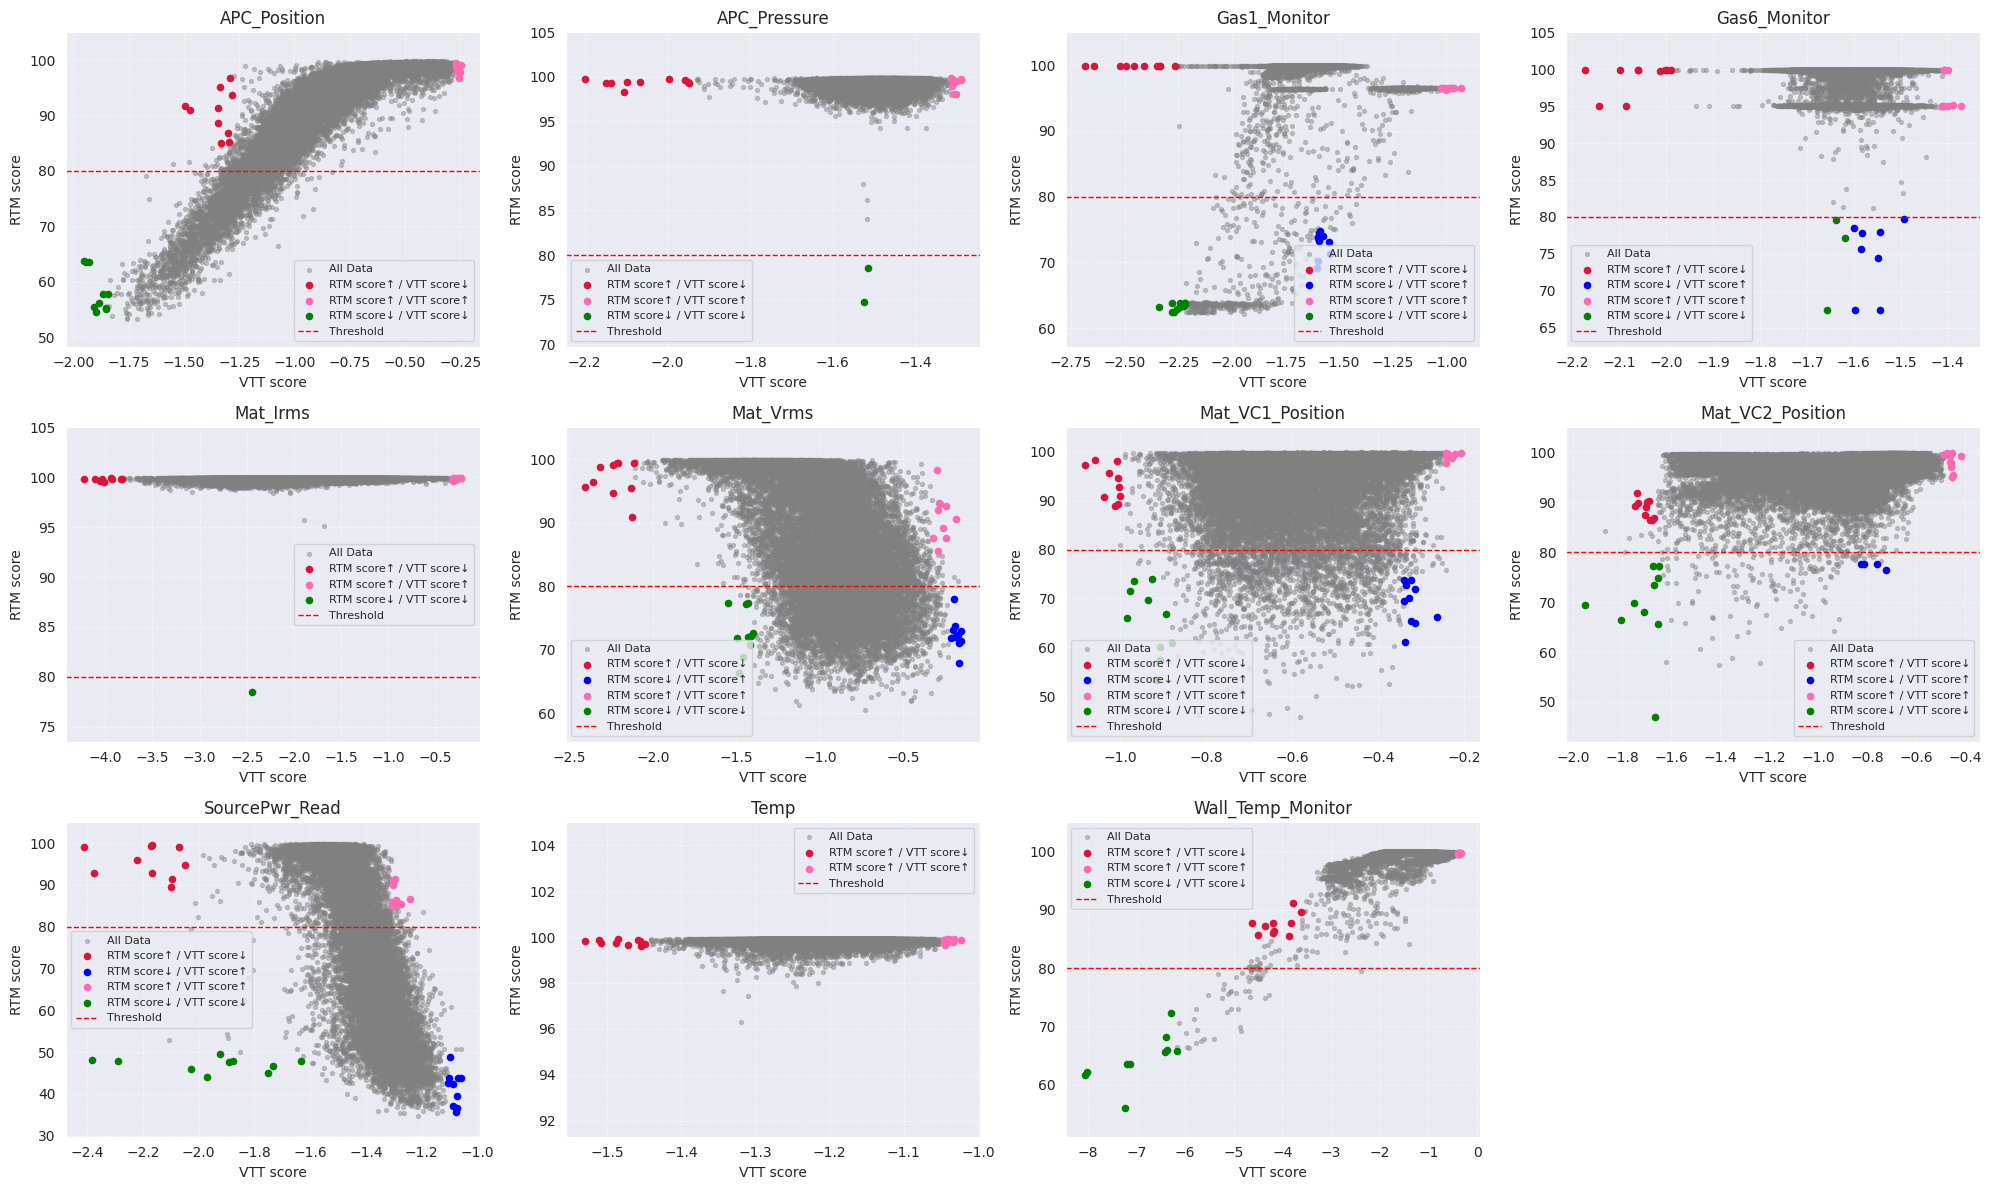

In [28]:
import seaborn as sns
sns.set_style('darkgrid')
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for idx, sensor in enumerate(sensor_columns):
    ax = axes[idx]
    try:
        x = vtt_RTM_combined[f'{sensor}_vtt']
        y = vtt_RTM_combined[f'{sensor}_score']
        df = pd.DataFrame({'uid': vtt_RTM_combined['unique_id'], 'x': x, 'y': y})

        cases = highlight_uids[sensor]

        # 전체 데이터 분포 (회색)
        ax.scatter(df['x'], df['y'], alpha=0.4, color='gray', s=8, label='All Data')

        colors = {
            'Left-Top': 'crimson',
            'Right-Bottom': 'blue',
            'Right-Top': 'hotpink',
            'Left-Bottom': 'green'
        }
        labels = {
            'Left-Top': 'RTM score↑ / VTT score↓',
            'Right-Bottom': 'RTM score↓ / VTT score↑',
            'Right-Top': 'RTM score↑ / VTT score↑',
            'Left-Bottom': 'RTM score↓ / VTT score↓'
        }

        for case, uids in cases.items():
            points = df[df['uid'].isin(uids)]
            if not points.empty:
                ax.scatter(points['x'], points['y'], color=colors[case], s=20, label=labels[case])

        # Threshold line
        ax.axhline(80, color='r', linewidth=1, linestyle='--', label='Threshold')

        ax.set_title(sensor)
        ax.set_xlabel('VTT score')
        ax.set_ylabel('RTM score')
        ax.set_ylim(y.min() - 5, 105)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(fontsize=8)

    except Exception as e:
        ax.set_title(f'{sensor} (Skipped)')
        ax.axis('off')

# 빈 서브플롯 비우기
for i in range(len(sensor_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [29]:
highlight_uids

{'APC_Position': {'Left-Top': ['20240318110454_D4039600-22',
   '20240318110454_D4039600-18',
   '20240123224923_D339FAV0-11',
   '20240422080434_D4121740-19',
   '20240206155009_D4024030-9',
   '20240203120137_D4013160-3',
   '20240409083013_D4038960-22',
   '20240402104316_D4069990-22',
   '20240206155009_D4024030-21',
   '20240509032220_D418R9K0-21'],
  'Right-Bottom': [],
  'Right-Top': ['20240118072649_D3499300-11',
   '20240203130818_D4013100-17',
   '20240126212502_D346FN10-15',
   '20240202152841_D4018720-15',
   '20240101153658_D3478480-17',
   '20240121170934_D337YAK0-4',
   '20240224060517_D347EDK0-8',
   '20240503044244_D4097QE0-21',
   '20240229130304_D4019970-10',
   '20240125233713_D3489970-21'],
  'Left-Bottom': ['20240708090303_D419BPB0-19',
   '20240708090303_D419BPB0-25',
   '20240708090303_D419BPB0-13',
   '20240705164540_D4226400-9',
   '20240708085955_D4219690-12',
   '20240707031946_D427Y1C0-19',
   '20240707031946_D427Y1C0-15',
   '20240710003117_D4209590-15',
 

In [30]:
import zipfile
import os

from glob import glob
from tqdm import tqdm
# P_FG_ch1 = pd.read_parquet("/home/iai3/Desktop/Bongjun/RTM/drystrip_3차/drystrip_dataset_v3/P_FG_60S_1_ref")
P_FG_ch1 = pd.read_parquet("/home/iai3/Desktop/Bongjun/RTM/drystrip_4차/bigger_train_df.parquet")
# /home/iai3/Desktop/Bongjun/RTM/drystrip_4차/bigger_train_df.parquet
interested_sensors = ['APC_Position', 'APC_Pressure', 'Gas1_Monitor', 'Gas6_Monitor', 'Mat_Irms', 'Mat_Phase','Mat_Vrms',
                      'Mat_VC1_Position', 'Mat_VC2_Position', 'SourcePwr_Read', 'Temp', 'Wall_Temp_Monitor']

filterd_df = pd.concat([P_FG_ch1[['time', 'lotid', 'wafer_number', 'Recipe_Step_Num']],P_FG_ch1[interested_sensors]], axis=1)
filterd_df = filterd_df.sort_values(by=["lotid", "wafer_number", "time"]).reset_index(drop=True)

indices_to_keep = set()
for (lot, wafer), group in tqdm(filterd_df.groupby(["lotid", "wafer_number"]), desc="Collecting Indices"):
    step_5_indices = group.loc[group["Recipe_Step_Num"].isin([4,5])].index
    indices_to_keep.update(step_5_indices)

In [31]:
step5_train_df = filterd_df.loc[sorted(indices_to_keep)].reset_index(drop=True)
final_train_df = step5_train_df.sort_values(by=["lotid", "wafer_number", "time"]).reset_index(drop=True)
grouped = list(final_train_df.groupby(['lotid', 'wafer_number'])) 
normal_groups = [group for group in grouped]
train_df = pd.concat([group[1] for group in normal_groups])
train_df_test = train_df.drop(columns='time')
train_df_test
train_df.groupby(['lotid','wafer_number','Recipe_Step_Num'])

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')

scaler = MinMaxScaler()
train_data_combined = train_df.iloc[:,4:]
train_scaled = scaler.fit_transform(train_data_combined)
train_scaled = pd.concat([train_df.iloc[:,:4], pd.DataFrame(train_scaled, columns=interested_sensors)], axis=1)
train_scaled = train_scaled.drop(columns=['time'])

interested_sensors = ['APC_Position', 'APC_Pressure', 'Gas1_Monitor', 'Gas6_Monitor', 'Mat_Irms', 'Mat_Phase','Mat_Vrms',
                      'Mat_VC1_Position', 'Mat_VC2_Position', 'SourcePwr_Read', 'Temp', 'Wall_Temp_Monitor']

In [108]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import random

sns.set_style("darkgrid")

def plot_selected_groups_reconstructed(
    preds, actuals, lotids, wafer_numbers, feature_names,
    highlight_uids, sensor_columns,
    ref_df=None,
    ref_max_count=100,
    output_dir="group_overlay_selected"
):
    os.makedirs(output_dir, exist_ok=True)

    lotids = np.array(lotids).astype(str)
    wafer_numbers = np.array(wafer_numbers).astype(str)
    unique_ids = np.char.add(lotids, np.char.add("-", wafer_numbers))

    W = preds.shape[1]
    D = preds.shape[2]

    colors = {
        'actual': 'blue',
        'predicted': 'magenta',
        'reference': 'orange'
    }

    for sensor_name in highlight_uids:
        if sensor_name not in sensor_columns:
            continue

        sensor_idx = sensor_columns.index(sensor_name)
        uid_dict = highlight_uids[sensor_name]

        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
        group_titles = ['Left-Bottom', 'Right-Top']

        for i, group in enumerate(group_titles):
            uids = uid_dict.get(group, [])
            ax = axes[i]
            ax.set_title(f'{sensor_name} | {group}', fontsize=12)

            # Reference 시계열
            if ref_df is not None and sensor_name in ref_df.columns:
                ref_grouped = ref_df.groupby(['lotid', 'wafer_number'])
                ref_keys = random.sample(list(ref_grouped.groups.keys()), min(ref_max_count, len(ref_grouped)))
                for key in ref_keys:
                    ref_series = ref_grouped.get_group(key).reset_index(drop=True)[sensor_name].values
                    ax.plot(ref_series, color=colors['reference'], alpha=0.3, linewidth=1.0, label='Reference' if key == ref_keys[0] else None)

            for uid in uids:
                indices = np.where(unique_ids == uid)[0]
                if len(indices) == 0:
                    continue

                uid_preds = preds[indices]
                uid_actuals = actuals[indices]
                total_len = uid_preds.shape[0] + W - 1

                pred_sum = np.zeros((total_len,))
                actual_sum = np.zeros((total_len,))
                count = np.zeros((total_len,))

                for j in range(uid_preds.shape[0]):
                    pred_sum[j:j+W] += uid_preds[j, :, sensor_idx]
                    actual_sum[j:j+W] += uid_actuals[j, :, sensor_idx]
                    count[j:j+W] += 1

                pred_seq = pred_sum / (count + 1e-8)
                actual_seq = actual_sum / (count + 1e-8)

                ax.plot(actual_seq, color=colors['actual'], alpha=0.6, linewidth=1.0, label='Actual' if uid == uids[0] else None)
                ax.plot(pred_seq, color=colors['predicted'], alpha=0.6, linewidth=1.0, label='Predicted' if uid == uids[0] else None)

            ax.grid(True, linestyle='--', alpha=0.5)
            ax.yaxis.set_major_locator(MultipleLocator(0.1))
            if i == 0:
                ax.set_ylabel('Value')
            ax.set_xlabel('Time')
            ax.legend(fontsize=8)

        fig.suptitle(f'{sensor_name} | Selected Group Comparison', fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        save_path = os.path.join(output_dir, f'{sensor_name}_left_right_bottom.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)

    return f"✅ 저장 완료: {output_dir}"


In [109]:
plot_selected_groups_reconstructed(
    preds=preds,
    actuals=actuals,
    lotids=lotids,
    wafer_numbers=wafer_numbers,
    feature_names=feature_names,
    highlight_uids=highlight_uids,
    sensor_columns=interested_sensors,
    ref_df=train_scaled,
    ref_max_count=1163,
    output_dir="group_overlay_selected"
)


'✅ 저장 완료: group_overlay_selected'

In [32]:
import json

with open('./case_ids.json', 'w') as f:
    json.dump(highlight_uids, f)

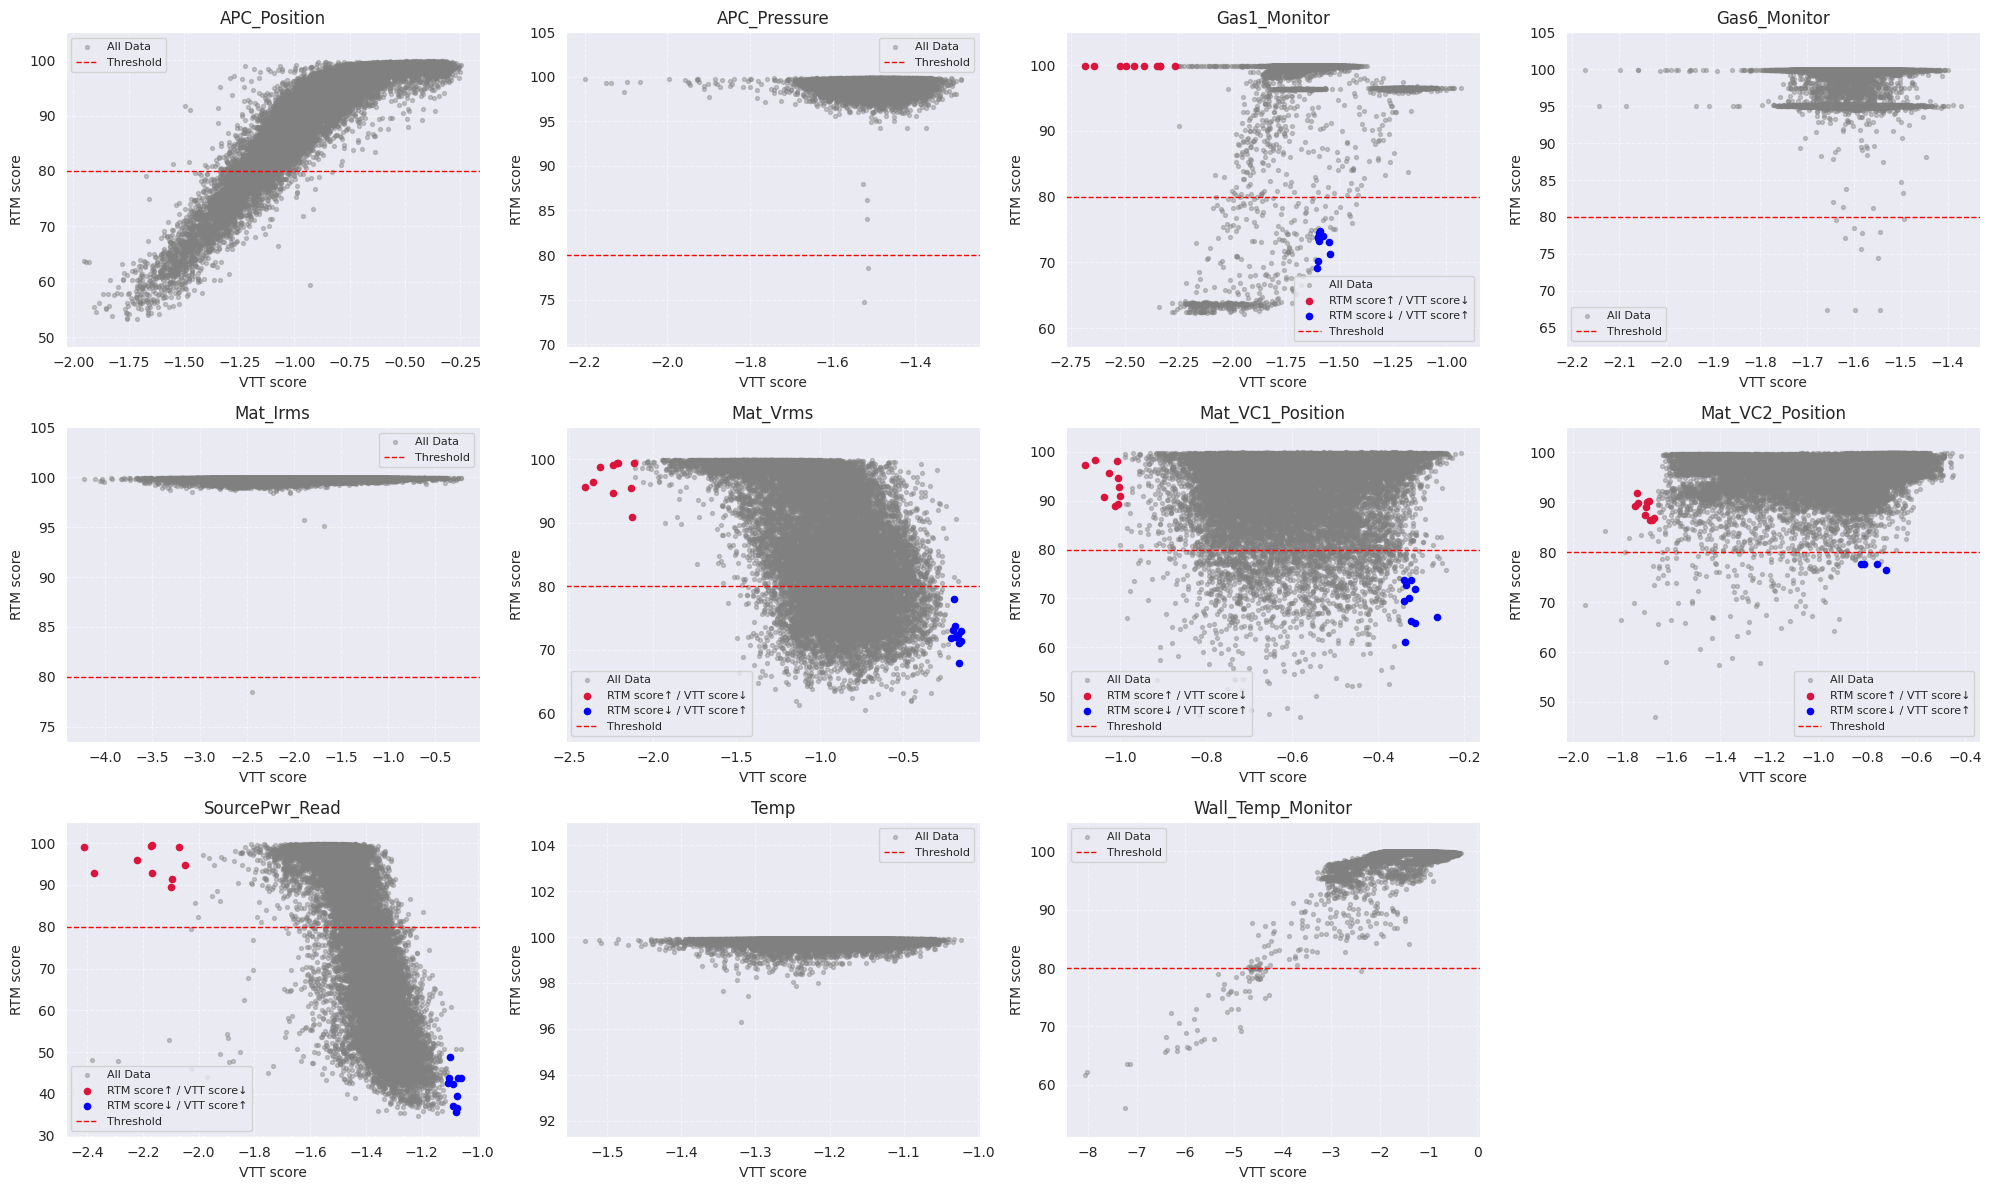

In [68]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for idx, sensor in enumerate(sensor_columns):
    ax = axes[idx]
    try:
        x = vtt_RTM_combined[f'{sensor}_vtt']
        y = vtt_RTM_combined[f'{sensor}_score']
        df = pd.DataFrame({'uid': vtt_RTM_combined['unique_id'], 'x': x, 'y': y})

        cases = highlight_uids[sensor]

        # 전체 데이터 분포 (회색)
        ax.scatter(df['x'], df['y'], alpha=0.4, color='gray', s=8, label='All Data')

        colors = {
            'Left-Top': 'crimson',
            'Right-Bottom': 'blue',
            'Right-Top': 'hotpink',
            'Left-Bottom': 'green'
        }
        labels = {
            'Left-Top': 'RTM score↑ / VTT score↓',
            'Right-Bottom': 'RTM score↓ / VTT score↑',
            'Right-Top': 'RTM score↑ / VTT score↑',
            'Left-Bottom': 'RTM score↓ / VTT score↓'
        }
        delete = ['Wall_Temp_Monitor', 'APC_Position', 'Mat_Irms', 'APC_Pressure', 'Gas6_Monitor', 'Temp']
        for case, uids in cases.items():
            
            if sensor in delete:
                continue
            
            if case == 'Left-Bottom':
                continue
            if case == 'Right-Top':
                continue
            points = df[df['uid'].isin(uids)]
            if not points.empty:
                ax.scatter(points['x'], points['y'], color=colors[case], s=20, label=labels[case])

        # Threshold line
        ax.axhline(80, color='r', linewidth=1, linestyle='--', label='Threshold')

        ax.set_title(sensor)
        ax.set_xlabel('VTT score')
        ax.set_ylabel('RTM score')
        ax.set_ylim(y.min() - 5, 105)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(fontsize=8)

    except Exception as e:
        ax.set_title(f'{sensor} (Skipped)')
        ax.axis('off')

# 빈 서브플롯 비우기
for i in range(len(sensor_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [122]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import random

sns.set_style("darkgrid")

def plot_selected_groups_reconstructed(
    preds, actuals, lotids, wafer_numbers, feature_names,
    highlight_uids, sensor_columns,
    ref_df=None,
    ref_max_count=100,
    output_dir="group_overlay_selected"
):
    os.makedirs(output_dir, exist_ok=True)

    lotids = np.array(lotids).astype(str)
    wafer_numbers = np.array(wafer_numbers).astype(str)
    unique_ids = np.char.add(lotids, np.char.add("-", wafer_numbers))

    W = preds.shape[1]
    D = preds.shape[2]

    colors = {
        'actual': 'blue',
        'predicted': 'magenta',
        'reference': 'orange'
    }

    for sensor_name in highlight_uids:
        if sensor_name not in sensor_columns:
            continue

        sensor_idx = sensor_columns.index(sensor_name)
        uid_dict = highlight_uids[sensor_name]

        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
        group_titles = ['Left-Top', 'Right-Bottom']

        for i, group in enumerate(group_titles):
            uids = uid_dict.get(group, [])
            ax = axes[i]
            ax.set_title(f'{sensor_name} | {group}', fontsize=12)

            # Reference 시계열
            if ref_df is not None and sensor_name in ref_df.columns:
                ref_grouped = ref_df.groupby(['lotid', 'wafer_number'])
                ref_keys = random.sample(list(ref_grouped.groups.keys()), min(ref_max_count, len(ref_grouped)))
                for key in ref_keys:
                    ref_series = ref_grouped.get_group(key).reset_index(drop=True)[sensor_name].values
                    ax.plot(ref_series, color=colors['reference'], alpha=0.3, linewidth=1.0, label='Reference' if key == ref_keys[0] else None)

            for uid in uids:
                indices = np.where(unique_ids == uid)[0]
                if len(indices) == 0:
                    continue

                uid_preds = preds[indices]
                uid_actuals = actuals[indices]
                total_len = uid_preds.shape[0] + W - 1

                pred_sum = np.zeros((total_len,))
                actual_sum = np.zeros((total_len,))
                count = np.zeros((total_len,))

                for j in range(uid_preds.shape[0]):
                    pred_sum[j:j+W] += uid_preds[j, :, sensor_idx]
                    actual_sum[j:j+W] += uid_actuals[j, :, sensor_idx]
                    count[j:j+W] += 1

                pred_seq = pred_sum / (count + 1e-8)
                actual_seq = actual_sum / (count + 1e-8)

                ax.plot(actual_seq, color=colors['actual'], alpha=0.6, linewidth=1.0, label='Actual' if uid == uids[0] else None)
                ax.plot(pred_seq, color=colors['predicted'], alpha=0.6, linewidth=1.0, label='Predicted' if uid == uids[0] else None)

            ax.grid(True, linestyle='--', alpha=0.5)
            ax.yaxis.set_major_locator(MultipleLocator(0.1))
            if i == 0:
                ax.set_ylabel('Value')
            ax.set_xlabel('Time')
            ax.legend(fontsize=8)

        fig.suptitle(f'{sensor_name}', fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        save_path = os.path.join(output_dir, f'{sensor_name}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)

    return f"✅ 저장 완료: {output_dir}"

plot_selected_groups_reconstructed(
    preds=preds,
    actuals=actuals,
    lotids=lotids,
    wafer_numbers=wafer_numbers,
    feature_names=feature_names,
    highlight_uids=highlight_uids,
    sensor_columns=interested_sensors,
    ref_df=train_scaled,
    ref_max_count=1163,
    output_dir="group_overlay_selected_LT_RB"
)


'✅ 저장 완료: group_overlay_selected_LT_RB'

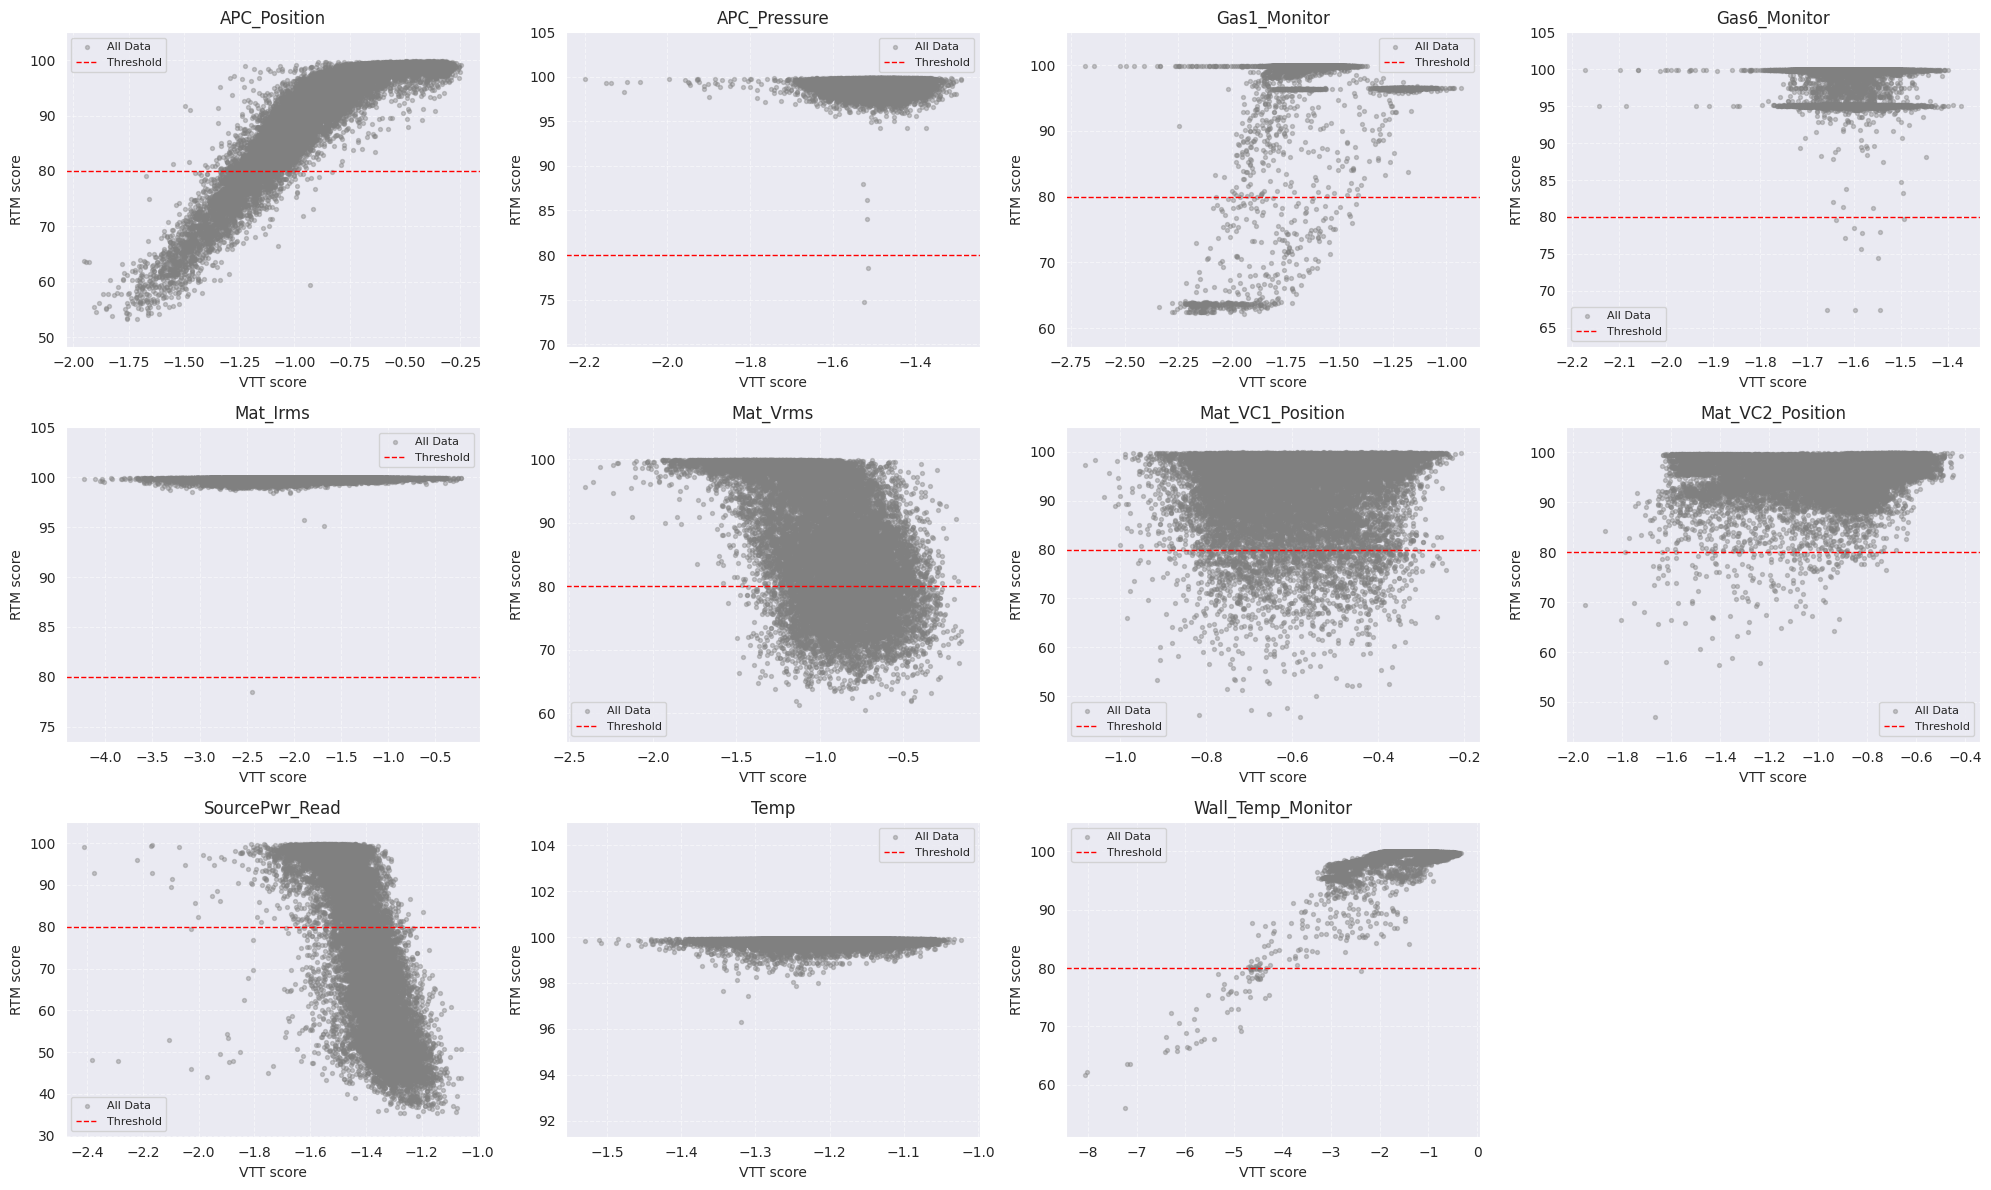

In [164]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for idx, sensor in enumerate(sensor_columns):
    ax = axes[idx]
    try:
        x = vtt_RTM_combined[f'{sensor}_vtt']
        y = vtt_RTM_combined[f'{sensor}_score']
        df = pd.DataFrame({'uid': vtt_RTM_combined['unique_id'], 'x': x, 'y': y})

        cases = highlight_uids[sensor]

        # 전체 데이터 분포 (회색)
        ax.scatter(df['x'], df['y'], alpha=0.4, color='gray', s=8, label='All Data')

        colors = {
            'Left-Top': 'crimson',
            'Right-Bottom': 'blue',
            'Right-Top': 'hotpink',
            'Left-Bottom': 'green'
        }
        labels = {
            'Left-Top': 'RTM score↑ / VTT score↓',
            'Right-Bottom': 'RTM score↓ / VTT score↑',
            'Right-Top': 'RTM score↑ / VTT score↑',
            'Left-Bottom': 'RTM score↓ / VTT score↓'
        }

        # for case, uids in cases.items():
        #     if case == 'Left-Bottom':
        #         continue
        #     if case == 'Right-Top':
        #         continue
        #     points = df[df['uid'].isin(uids)]
        #     if not points.empty:
        #         ax.scatter(points['x'], points['y'], color=colors[case], s=20, label=labels[case])

        # Threshold line
        ax.axhline(80, color='r', linewidth=1, linestyle='--', label='Threshold')

        ax.set_title(sensor)
        ax.set_xlabel('VTT score')
        ax.set_ylabel('RTM score')
        ax.set_ylim(y.min() - 5, 105)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(fontsize=8)

    except Exception as e:
        ax.set_title(f'{sensor} (Skipped)')
        ax.axis('off')

# 빈 서브플롯 비우기
for i in range(len(sensor_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# XAI

In [51]:
def get_input_by_uid(preds, actuals, lotids, wafer_numbers, target_uid):
    """
    주어진 UID에 해당하는 window들을 abnormal_input으로 반환
    """
    unique_ids = np.char.add(lotids, np.char.add("-", wafer_numbers))
    indices = np.where(unique_ids == target_uid)[0]
    if len(indices) == 0:
        raise ValueError(f"UID '{target_uid}'에 해당하는 window 없음")

    input_windows = actuals[indices]  # 예측 대상은 actual (input)
    return torch.tensor(input_windows).float()  # (B, W, D)


In [52]:
def calc_diff_attns(prior, post):
    diff = post - prior
    diff = np.abs(diff)
    diff = np.mean(diff, axis=(0, 1, 2))
    diff.shape
    return diff

In [74]:
target_uid = highlight_uids["Mat_Irms"]["Right-Top"][0]  # 예시: 첫 번째 UID
input = get_input_by_uid(preds, actuals, lotids, wafer_numbers, target_uid).to(device)

model.model.eval()
with torch.no_grad():
    input_prior_pred, [input_prior_vattn, input_prior_tattn] = model.model(input, use_attn=True)
    input_post_pred, [input_post_vattn, input_post_tattn] = model.model(input_prior_pred, use_attn=True)

normal_prior_score = model._select_criterion()(input, input_prior_pred).cpu().detach().numpy().mean()
normal_post_score = model._select_criterion()(input_prior_pred, input_post_pred).cpu().detach().numpy().mean()
print(f'Prior score: {normal_prior_score:.6f}, Post score: {normal_post_score:.6f}')

input_prior_vattn = input_prior_vattn.cpu().detach().numpy()
input_post_vattn = input_post_vattn.cpu().detach().numpy()

input_diff = calc_diff_attns(input_prior_vattn, input_post_vattn)


Prior score: 0.000033, Post score: 0.000005


In [77]:
input_post_vattn.shape

(3, 5430, 4, 12, 12)

In [82]:
input_prior_vattn.shape

(3, 5430, 4, 12, 12)

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcl

def check_attn(diff, column):
    """
    Attention map에서 각 특징의 변화도를 heatmap으로 시각화합니다.
    컬럼명은 정렬 및 회전 적용되고, 각 셀에 수치가 annotate됩니다.
    """
    assert diff.shape[0] == diff.shape[1] == len(column), "열 개수와 diff shape 불일치"

    plt.figure(figsize=(12, 10))
    h, s, v = 24, 0.99, 0.99
    colors = [
        mcl.hsv_to_rgb((h/360, 0, v)),
        mcl.hsv_to_rgb((h/360, 0.5, v)),
        mcl.hsv_to_rgb((h/360, 1, v))
    ]
    cmap = LinearSegmentedColormap.from_list('my_cmap', colors, gamma=3)

    ax = sns.heatmap(
        diff,
        cmap=cmap,
        annot=True,
        fmt=".4f",
        annot_kws={"size": 8},
        xticklabels=column,
        yticklabels=column,
        cbar=True,
        # linewidths=0.5,
        # linecolor='gray'
    )

    # 스타일 정리
    ax.xaxis.tick_top()
    plt.xticks(rotation=90, ha='center', fontsize=10)
    plt.yticks(rotation=0, va='center', fontsize=10)

    plt.title('Change of Correlations', fontsize=14)
    plt.tight_layout()
    return plt


def check_contribution(diff, column, axis=1):
    """
    Attention map에서 각 특징의 기여도를 확인합니다.

    Parameters
    ----------
    diff : np.ndarray
        차이 값을 나타내는 배열 (shape: [seq_length, seq_length])
    columns : list
        열 이름 리스트
    axis : int, optional
        축 (기본값: 1, 시퀀스 길이 차원)

    Returns
    -------
    plt : matplotlib.pyplot
        생성된 플롯
    """
    # 각 축에 따라 차이 값 합계
    inter_value = np.sum(diff, axis=axis) # 변수(특징) 별로 합산
    sum_inter_value = np.sum(inter_value)
    inter_value = inter_value/sum_inter_value
    
    # 정렬된 인덱스 및 레이블
    sorted_index = np.argsort(inter_value)
    label = np.array(column)[sorted_index]
    
    # 플롯 생성
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_visible(False)
    plt.grid(linestyle = ':', linewidth = 2, axis = 'x')
    
    index = np.arange(1, len(inter_value) + 1)
    ax.barh(index, inter_value[sorted_index])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_yaxis().set_visible(True)
    
    plt.yticks(index, label, fontsize=10)
    plt.title('Contribution of features')
    plt.ylabel('Features')
    
    return plt

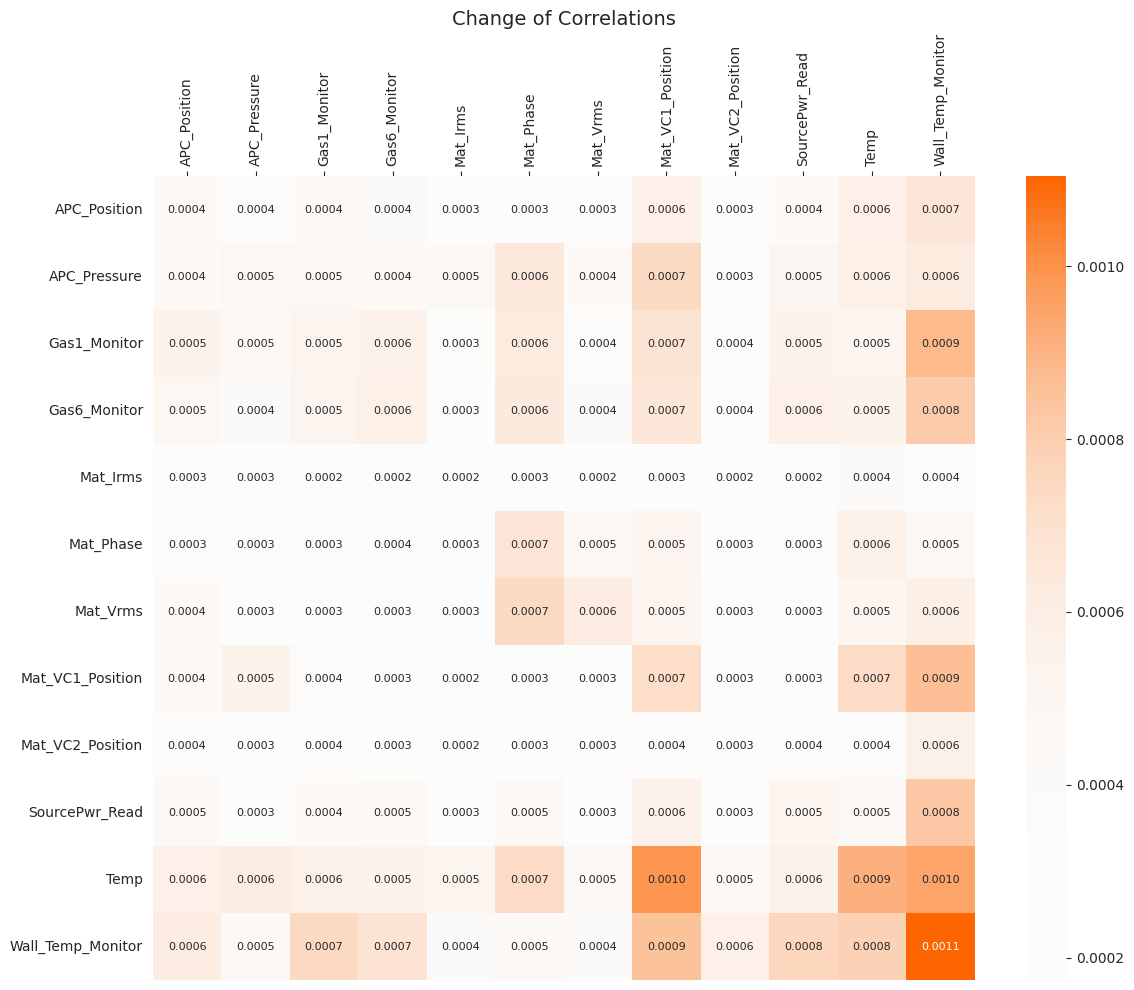

In [38]:
check_attn(input_diff, feature_names)
plt.show()

In [79]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcl

def save_attn_diff_per_wafer_all(
    preds, actuals, lotids, wafer_numbers, highlight_uids, model, feature_names, save_root='attn_diff_results', device='cuda'
):
    """
    변수별 → case별 → 웨이퍼별로 attention 차이 시각화 PNG 저장

    Args:
        preds, actuals: numpy arrays of shape (N, W, D)
        lotids, wafer_numbers: bytes or str arrays
        highlight_uids: dict: sensor -> {case -> [uid list]}
        model: VTTSAT 모델 (forward 시 use_attn=True 지원)
        feature_names: 센서 이름 리스트
        save_root: 저장 루트 디렉토리
        device: 'cuda' or 'cpu'
    """

    os.makedirs(save_root, exist_ok=True)
    model.model.eval()

    for sensor in feature_names:
        sensor_uid_dict = highlight_uids.get(sensor, {})
        # for case in ['Right-Top', 'Left-Bottom']:
        for case in ['Right-Bottom', 'Left-Top']:
            uids = sensor_uid_dict.get(case, [])
            for uid in uids:
                try:
                    input_seq = get_input_by_uid(preds, actuals, lotids, wafer_numbers, uid).to(device)
                    with torch.no_grad():
                        prior_pred, [prior_vattn, _] = model.model(input_seq, use_attn=True)
                        post_pred, [post_vattn, _] = model.model(prior_pred, use_attn=True)

                    prior_vattn = prior_vattn.cpu().detach().numpy()  # 마지막 블록의 attention
                    post_vattn = post_vattn.cpu().detach().numpy()
                    diff = calc_diff_attns(prior_vattn, post_vattn)  # (D, D)

                    plt.figure(figsize=(12, 10))
                    h, s, v = 24, 0.99, 0.99
                    colors = [
                        mcl.hsv_to_rgb((h/360, 0, v)),
                        mcl.hsv_to_rgb((h/360, 0.5, v)),
                        mcl.hsv_to_rgb((h/360, 1, v))
                    ]
                    cmap = LinearSegmentedColormap.from_list('my_cmap', colors, gamma=3)

                    ax = sns.heatmap(
                        diff,
                        cmap=cmap,
                        annot=True,
                        fmt=".4f",
                        annot_kws={"size": 8},
                        xticklabels=feature_names,
                        yticklabels=feature_names,
                        cbar=True,
                        # linewidths=0.5,
                        # linecolor='gray'
                    )

                    # 스타일 정리
                    ax.xaxis.tick_top()
                    plt.xticks(rotation=90, ha='center', fontsize=10)
                    plt.yticks(rotation=0, va='center', fontsize=10)

                    plt.title('Change of Correlations', fontsize=14)
                    plt.tight_layout()

                    save_dir = os.path.join(save_root, sensor, case)
                    os.makedirs(save_dir, exist_ok=True)
                    save_path = os.path.join(save_dir, f'{uid}_attn_diff.png')
                    plt.savefig(save_path, dpi=300, bbox_inches='tight')
                    plt.close()

                except Exception as e:
                    print(f"[에러] {sensor} | {case} | {uid} 처리 중 오류 발생: {e}")


In [80]:
save_attn_diff_per_wafer_all(preds, actuals, lotids, wafer_numbers, highlight_uids, model, feature_names, save_root='attn_diff_results', device='cuda')


In [90]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcl
from collections import defaultdict
def save_attn_diff_per_wafer_train(trainloader, model, feature_names, save_root='attn_diff_results_train', device='cuda'):
    """
    UID 기준으로 window들을 모아 모델에 넣고 attention diff heatmap 저장
    """
    os.makedirs(save_root, exist_ok=True)
    model.model.eval()

    # UID별 window들을 모음
    uid_to_windows = defaultdict(list)

    # window 단위 → UID 단위로 수집
    for i in range(len(trainloader.dataset)):
        sample = trainloader.dataset[i]
        lotid = sample['lotid']
        wafer = sample['wafer_number']
        uid = f"{lotid}-{wafer}"

        uid_to_windows[uid].append(sample['given'])

    for uid, window_list in uid_to_windows.items():
        try:
            input_tensor = torch.tensor(np.stack(window_list)).float().to(device)  # (B, W, D)

            with torch.no_grad():
                prior_pred, [prior_vattn, _] = model.model(input_tensor, use_attn=True)
                post_pred, [post_vattn, _] = model.model(prior_pred, use_attn=True)

            prior_vattn = prior_vattn.cpu().detach().numpy()
            post_vattn = post_vattn.cpu().detach().numpy()
            diff = calc_diff_attns(prior_vattn, post_vattn)  # (D, D)

            # 시각화 및 저장
            plt.figure(figsize=(12, 10))
            h, s, v = 24, 0.99, 0.99
            colors = [
                mcl.hsv_to_rgb((h/360, 0, v)),
                mcl.hsv_to_rgb((h/360, 0.5, v)),
                mcl.hsv_to_rgb((h/360, 1, v))
            ]
            cmap = LinearSegmentedColormap.from_list('my_cmap', colors, gamma=3)

            ax = sns.heatmap(
                diff,
                cmap=cmap,
                annot=True,
                fmt=".4f",
                annot_kws={"size": 8},
                xticklabels=feature_names,
                yticklabels=feature_names,
                cbar=True
            )

            ax.xaxis.tick_top()
            plt.xticks(rotation=90, ha='center', fontsize=10)
            plt.yticks(rotation=0, va='center', fontsize=10)
            plt.title(f'Change of Correlations: {uid}', fontsize=14)
            plt.tight_layout()

            save_path = os.path.join(save_root, f'{uid}_attn_diff.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"[저장 완료] {save_path}")

        except Exception as e:
            print(f"[에러] {uid} 처리 중 오류 발생: {e}")


In [91]:
save_attn_diff_per_wafer_train(
    trainloader=trainloader,
    model=model,
    feature_names=feature_names,
    save_root='attn_diff_results_train',
    device='cuda'
)

[저장 완료] attn_diff_results_train/20231214155931_D3428610-15_attn_diff.png
[저장 완료] attn_diff_results_train/20231214155931_D3428610-21_attn_diff.png
[저장 완료] attn_diff_results_train/20231214155931_D3428610-3_attn_diff.png
[저장 완료] attn_diff_results_train/20231214155931_D3428610-9_attn_diff.png
[저장 완료] attn_diff_results_train/20231214163232_D3447QV0-14_attn_diff.png
[저장 완료] attn_diff_results_train/20231214163232_D3447QV0-2_attn_diff.png
[저장 완료] attn_diff_results_train/20231214163232_D3447QV0-25_attn_diff.png
[저장 완료] attn_diff_results_train/20231214165356_D3448530-1_attn_diff.png
[저장 완료] attn_diff_results_train/20231214165356_D3448530-13_attn_diff.png
[저장 완료] attn_diff_results_train/20231214165356_D3448530-19_attn_diff.png
[저장 완료] attn_diff_results_train/20231214165356_D3448530-25_attn_diff.png
[저장 완료] attn_diff_results_train/20231214165356_D3448530-7_attn_diff.png
[저장 완료] attn_diff_results_train/20231214174642_D3436400-1_attn_diff.png
[저장 완료] attn_diff_results_train/20231214174642_D3436400-1

- XAI 테스트를 위한 정상, 비정상 input window 구성

In [28]:
# 100 길이의 연속된 1을 찾기 위한 커널
kernel = np.ones(100)

# 이동 합계를 계산
convolved = np.convolve(test_label, kernel, mode='valid')

# 이동 합계가 100인 인덱스를 찾기
indices = np.where(convolved == 100)[0]

print("연속적으로 100개의 1이 등장하는 시작 인덱스:", indices)

연속적으로 100개의 1이 등장하는 시작 인덱스: [  1754   1755   1756 ... 445089 445090 445091]


In [40]:
normal_window = testset[:args.window_size]
abnormal_window = testset[indices[0]:indices[0]+args.window_size]

normal_input = torch.Tensor(normal_window).unsqueeze(0).to(model.device)
abnormal_input = torch.Tensor(abnormal_window).unsqueeze(0).to(model.device)

- VTT 모델을 통해 variable, temporl attention 도출

In [41]:
model.model.eval()
with torch.no_grad():
    nor_prior_pred, [nor_prior_vattn, nor_prior_tattn] = model.model(normal_input, use_attn=True)
    nor_post_pred, [nor_post_vattn, nor_post_tattn] = model.model(nor_prior_pred, use_attn=True)

    normal_prior_score = model._select_criterion()(nor_prior_pred, normal_input).cpu().detach().numpy().mean()
    normal_post_score = model._select_criterion()(nor_post_pred, nor_prior_pred).cpu().detach().numpy().mean()

    print(f'Normal | Prior score: {normal_prior_score:.6f}, Post score: {normal_post_score:.6f}')

    abnor_prior_pred, [abnor_prior_vattn, abnor_prior_tattn] = model.model(abnormal_input, use_attn=True)
    abnor_post_pred, [abnor_post_vattn, abnor_post_tattn] = model.model(abnor_prior_pred, use_attn=True)

    abnormal_prior_score = model._select_criterion()(abnor_prior_pred, abnormal_input).cpu().detach().numpy().mean()
    abnormal_post_score = model._select_criterion()(abnor_post_pred, abnor_prior_pred).cpu().detach().numpy().mean()

    print(f'Abnormal | Prior score: {abnormal_prior_score:.6f}, Post score: {abnormal_post_score:.6f}')

Normal | Prior score: 0.005130, Post score: 0.005598
Abnormal | Prior score: 0.014580, Post score: 0.008810


In [42]:
nor_prior_vattn = nor_prior_vattn.cpu().detach().numpy()
nor_prior_tattn = nor_prior_tattn.cpu().detach().numpy()
nor_post_vattn = nor_post_vattn.cpu().detach().numpy()
nor_post_tattn = nor_post_tattn.cpu().detach().numpy()

abnor_prior_vattn = abnor_prior_vattn.cpu().detach().numpy()
abnor_prior_tattn = abnor_prior_tattn.cpu().detach().numpy()
abnor_post_vattn = abnor_post_vattn.cpu().detach().numpy()
abnor_post_tattn = abnor_post_tattn.cpu().detach().numpy()

- 원본 데이터에서 추출한 attention map과 재구성된 데이터에서 추출한 attention map을 비교

In [34]:
def calc_diff_attns(prior, post):
    diff = post - prior
    diff = np.abs(diff)
    diff = np.mean(diff, axis=(0, 1, 2))
    diff.shape
    return diff

In [43]:
nor_diff = calc_diff_attns(nor_prior_vattn, nor_post_vattn)
abnor_diff = calc_diff_attns(abnor_prior_vattn, abnor_post_vattn)

- attention 변화에 대한 시각화 결과

In [78]:
def check_attn(diff, column):
    """
    Attention map에서 각 특징의 변화도를 확인합니다.

    Parameters
    ----------
    diff : np.ndarray
        차이 값을 나타내는 배열 (shape: [seq_length, seq_length])
    columns : list
        열 이름 리스트
    axis : int, optional
        축 (기본값: 1, 시퀀스 길이 차원)
    
    Returns
    -------
    plt : matplotlib.pyplot
        생성된 플롯
    """
    # 인덱스 생성
    index = range(1, diff.shape[0]+1)
    
    # 플롯 생성
    plt.figure(figsize=(12, 10))
    h, s, v = 24, 0.99, 0.99
    colors = [
        mcl.hsv_to_rgb((h/360,0,v)),
        mcl.hsv_to_rgb((h/360,0.5,v)),
        mcl.hsv_to_rgb((h/360,1,v))
    ]
    cmap = LinearSegmentedColormap.from_list('my_cmap',colors,gamma=3)
    
    ax = sns.heatmap(diff, cmap=cmap)
    
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    
    ax.xaxis.tick_top()
    
    plt.xticks(index, column, fontsize=10, rotation=90)
    plt.yticks(index, column, fontsize=10)
    plt.title('change of correlations')
    
    return plt

def check_contribution(diff, column, axis=1):
    """
    Attention map에서 각 특징의 기여도를 확인합니다.

    Parameters
    ----------
    diff : np.ndarray
        차이 값을 나타내는 배열 (shape: [seq_length, seq_length])
    columns : list
        열 이름 리스트
    axis : int, optional
        축 (기본값: 1, 시퀀스 길이 차원)

    Returns
    -------
    plt : matplotlib.pyplot
        생성된 플롯
    """
    # 각 축에 따라 차이 값 합계
    inter_value = np.sum(diff, axis=axis) # 변수(특징) 별로 합산
    sum_inter_value = np.sum(inter_value)
    inter_value = inter_value/sum_inter_value
    
    # 정렬된 인덱스 및 레이블
    sorted_index = np.argsort(inter_value)
    label = np.array(column)[sorted_index]
    
    # 플롯 생성
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_visible(False)
    plt.grid(linestyle = ':', linewidth = 2, axis = 'x')
    
    index = np.arange(1, len(inter_value) + 1)
    ax.barh(index, inter_value[sorted_index])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_yaxis().set_visible(True)
    
    plt.yticks(index, label, fontsize=10)
    plt.title('Contribution of features')
    plt.ylabel('Features')
    
    return plt

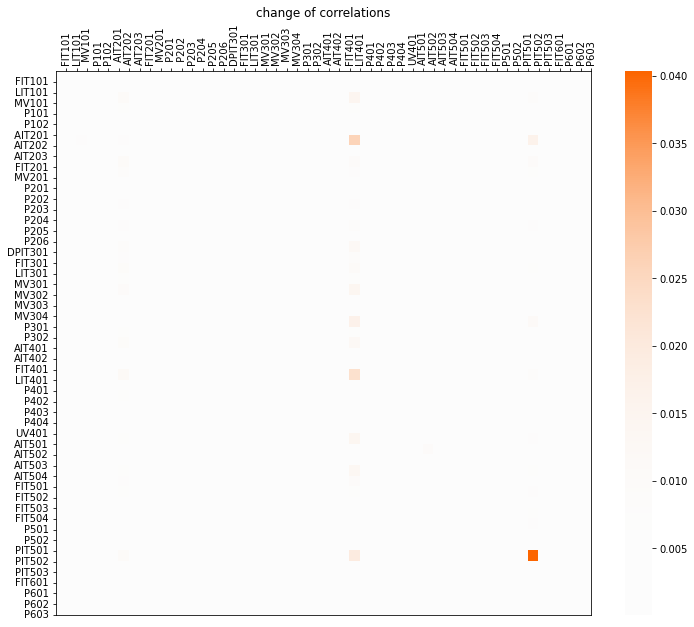

In [79]:
check_attn(nor_diff, columns)
plt.show()

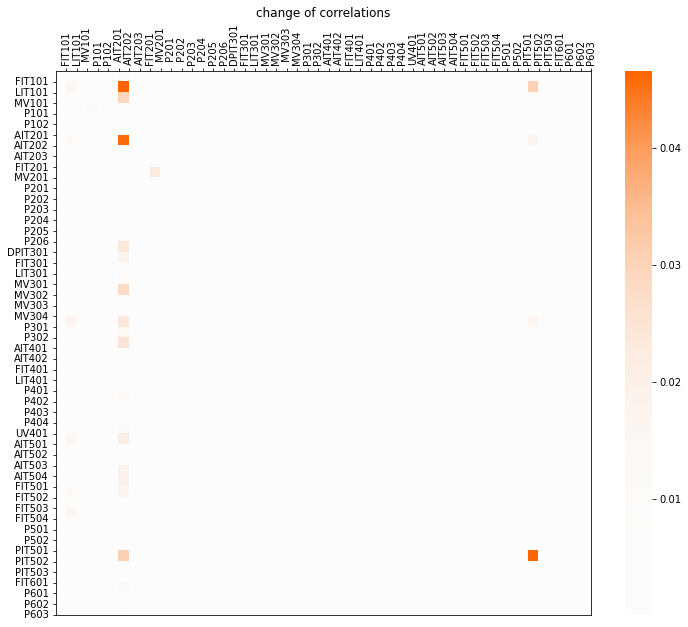

In [80]:
check_attn(abnor_diff, columns)
plt.show()

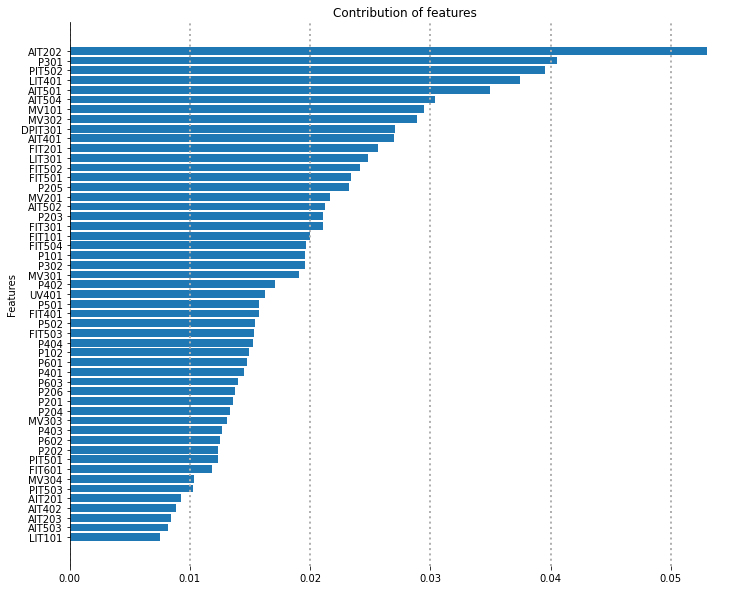

In [72]:
check_contribution(nor_diff, columns)
plt.show()

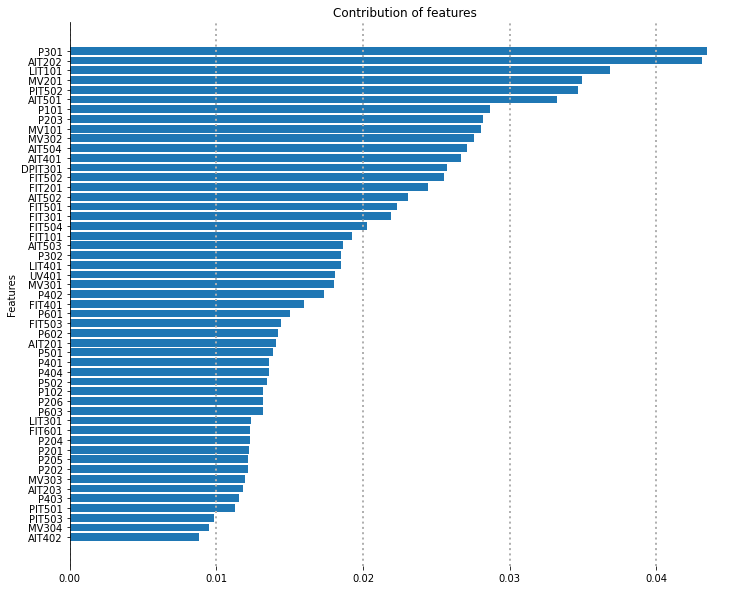

In [73]:
check_contribution(abnor_diff, columns)
plt.show()

---

### STEP 10. 명령어로 실행

```
python main.py \
--train \
--test \
--model VTTPAT \
--dataname SWaT \
--use_multi_gpu \
--devices 0,1
```

---

# 레기통

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_style("darkgrid")
def plot_stacked_anomaly_scores_all_wafers(
    dist_per_feature,
    lotid,
    wafer_number,
    feature_names,
    num_wafers=1000,
    output_dir='recon_vis_overlay'
):
    """
    모든 웨이퍼 데이터를 센서별로 겹쳐서 anomaly score 시각화
    """
    os.makedirs(output_dir, exist_ok=True)

    np.random.seed(42)
    lotid = np.array(lotid).astype(str)
    wafer_number = np.array(wafer_number).astype(str)
    unique_ids = np.char.add(lotid, np.char.add("-", wafer_number))
    unique_wafer_ids = np.unique(unique_ids)
    selected_ids = np.random.choice(unique_wafer_ids, size=min(num_wafers, len(unique_wafer_ids)), replace=False)

    records = []

    for uid in selected_ids:
        indices = np.where(unique_ids == uid)[0]
        if len(indices) == 0:
            continue

        uid_score = dist_per_feature[indices]  # (num_win, W, D)
        W = uid_score.shape[1]
        D = uid_score.shape[2]
        total_len = uid_score.shape[0] + W - 1  # stride=1

        score_sum = np.zeros((total_len, D))
        count = np.zeros((total_len, D))

        for i in range(len(indices)):
            score_sum[i:i + W] += uid_score[i]
            count[i:i + W] += 1

        score_avg = score_sum / (count + 1e-8)

        for d in range(D):
            records.append({
                'sensor': feature_names[d],
                'uid': uid,
                'time': np.arange(total_len),
                'score': score_avg[:, d]
            })

    # 센서별로 그래프 그리기
    for d, sensor in enumerate(feature_names):
        plt.figure(figsize=(12, 4))
        for rec in records:
            if rec['sensor'] != sensor:
                continue
            plt.plot(rec['time'], rec['score'], alpha=0.5)

        plt.title(f"All Wafers Overlapped | Sensor: {sensor}")
        plt.xlabel("Time")
        plt.ylabel("Anomaly Score")
        plt.tight_layout()
        save_path = os.path.join(output_dir, f"overlay_{sensor}.png")
        plt.savefig(save_path)
        plt.close()

    return f"✅ 저장 완료: {output_dir}"


In [ ]:
preds, actuals, dist_per_feature, lotids, wafer_numbers, step_nums = dist

dist_per_feature = (preds - actuals) **2

In [ ]:
# lotid, wafer_number, step_num도 inference 시점에서 수집되었다면:
plot_stacked_anomaly_scores_all_wafers(
    dist_per_feature=dist_per_feature,
    lotid=lotids,
    wafer_number=wafer_numbers,
    feature_names=feature_names,
    num_wafers=1000,
    output_dir='recon_vis_overlay'
)


'✅ 저장 완료: recon_vis_overlay'

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_wafer_level_kde_per_feature(
    dist_per_feature,
    lotid,
    wafer_number,
    feature_names,
    output_dir='wafer_kde_per_feature'
):
    """
    센서(feature)별로, 웨이퍼 단위 anomaly score 평균을 계산 후 KDE 분포 시각화
    저장 경로: output_dir/feature_name.png
    """
    os.makedirs(output_dir, exist_ok=True)

    lotid = np.array(lotid).astype(str)
    wafer_number = np.array(wafer_number).astype(str)
    unique_ids = np.char.add(lotid, np.char.add("-", wafer_number))
    unique_wafer_ids = np.unique(unique_ids)

    D = dist_per_feature.shape[2]

    for d, feat in enumerate(feature_names):
        wafer_scores = []

        for uid in unique_wafer_ids:
            indices = np.where(unique_ids == uid)[0]
            if len(indices) == 0:
                continue

            uid_score = dist_per_feature[indices]  # (num_win, W, D)
            uid_score_feat = uid_score[:, :, d]    # (num_win, W)
            mean_score = np.mean(uid_score_feat)   # scalar
            wafer_scores.append(mean_score)

        # KDE plot
        plt.figure(figsize=(8, 5))
        sns.kdeplot(wafer_scores, fill=True, color='darkorange', alpha=0.6)
        plt.title(f"Wafer-Level Anomaly Score KDE | Feature: {feat}", fontsize=14)
        plt.xlabel("Mean Anomaly Score", fontsize=12)
        plt.ylabel("Density", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        save_path = os.path.join(output_dir, f'kde_{feat}.png')
        plt.savefig(save_path)
        plt.close()

    return f"✅ 저장 완료 (각 feature별 KDE): {output_dir}"


In [ ]:
plot_wafer_level_kde_per_feature(
    dist_per_feature=dist_per_feature,
    lotid=lotids,
    wafer_number=wafer_numbers,
    feature_names=feature_names,
    output_dir='wafer_kde_per_feature'
)


KeyboardInterrupt: 

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# 설정
sns.set_style("darkgrid")
np.random.seed(42)


def average_overlapping_predictions(pred, actual, lotid, wafer_number, step_num):
    """
    겹치는 window 기반 예측 결과를 시점 단위로 평균 복원
    Args:
        pred: (N, W, D)
        actual: (N, W, D)
        lotid: (N,) str
        wafer_number: (N,) str
        step_num: (N,) int
    Returns:
        DataFrame with columns:
            'time', 'sensor', 'value', 'type', 'unique_id', 'step_num'
    """
    unique_ids = np.char.add(lotid.astype(str), np.char.add("-", wafer_number.astype(str)))
    unique_wafer_keys = np.unique(unique_ids)

    records = []

    for uid in unique_wafer_keys:
        indices = np.where(unique_ids == uid)[0]
        if len(indices) == 0:
            continue

        uid_pred = pred[indices]  # (num_win, W, D)
        uid_actual = actual[indices]
        uid_step = step_num[indices[0]]

        total_len = uid_pred.shape[0] + uid_pred.shape[1] - 1  # stride = 1
        D = uid_pred.shape[2]

        pred_sum = np.zeros((total_len, D))
        actual_sum = np.zeros((total_len, D))
        count = np.zeros((total_len, D))

        for i, idx in enumerate(indices):
            pred_sum[i:i + pred.shape[1]] += pred[idx]
            actual_sum[i:i + pred.shape[1]] += actual[idx]
            count[i:i + pred.shape[1]] += 1

        pred_mean = pred_sum / (count + 1e-8)
        actual_mean = actual_sum / (count + 1e-8)

        for t in range(total_len):
            for d in range(D):
                records.append({
                    'time': t,
                    'sensor': f'S{d}',
                    'value': actual_mean[t, d],
                    'type': 'actual',
                    'unique_id': uid,
                    'step_num': uid_step
                })
                records.append({
                    'time': t,
                    'sensor': f'S{d}',
                    'value': pred_mean[t, d],
                    'type': 'pred',
                    'unique_id': uid,
                    'step_num': uid_step
                })

    return pd.DataFrame.from_records(records)


def visualize_reconstruction_result(h5_path, output_dir='recon_vis', num_wafers=1000):
    os.makedirs(output_dir, exist_ok=True)

    # Load h5
    with h5py.File(h5_path, 'r') as f:
        pred = f['pred'][:]            # (N, W, D)
        actual = f['actual'][:]        # (N, W, D)
        lotid = f['lotid'][:].astype(str)
        wafer_number = f['wafer_number'][:].astype(str)
        step_num = f['step_num'][:]

    unique_ids = np.char.add(lotid, np.char.add("-", wafer_number))
    unique_wafer_ids = np.unique(unique_ids)

    selected_ids = np.random.choice(unique_wafer_ids, size=min(num_wafers, len(unique_wafer_ids)), replace=False)

    # Averaging and long-format dataframe 생성
    df = average_overlapping_predictions(pred, actual, lotid, wafer_number, step_num)
    df = df[df['unique_id'].isin(selected_ids)]

    # Plot
    for uid in selected_ids:
        sub_df = df[df['unique_id'] == uid]
        step = sub_df['step_num'].iloc[0]

        sensors = sub_df['sensor'].unique()
        for sensor in sensors:
            sensor_df = sub_df[sub_df['sensor'] == sensor]
            plt.figure(figsize=(12, 4))
            for typ, color in zip(['actual', 'pred'], ['blue', 'magenta']):
                part = sensor_df[sensor_df['type'] == typ]
                plt.plot(part['time'], part['value'], label=typ, alpha=0.7, linewidth=1)

            plt.title(f'{uid} | Step {step} | Sensor {sensor}')
            plt.xlabel('Time')
            plt.ylabel('Value')
            plt.legend()
            plt.tight_layout()
            save_path = os.path.join(output_dir, f'{uid}_step{step}_{sensor}.png')
            plt.savefig(save_path)
            plt.close()

    return f"✅ 저장 완료: {output_dir}"

# 실행 예시
visualize_reconstruction_result('../src/logs/GDN_step45_big_ref/VTTSAT/version10/results/inference_result_with_metadata.h5', output_dir='recon_vis', num_wafers=10)


KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
sns.set_style("darkgrid")

def reconstruct_sequence_by_wafer_with_subplots_v2(
    preds,
    actuals,
    lotids,
    wafer_numbers,
    feature_names,
    output_dir='recon_per_wafer_subplots_v2',
    num_wafer_to_plot=10,
    random_seed=42
):
    """
    VTT reconstruction 결과를 랜덤으로 선택된 웨이퍼 몇 개만 subplot 시각화 (센서별 Actual vs Predicted).
    시각 스타일은 기존 attention 시각화 스타일을 참고하여 통일성 있게 구성.

    Args:
        preds: (N, W, D)
        actuals: (N, W, D)
        lotids: list of str, len = N
        wafer_numbers: list of str, len = N
        feature_names: list of str, len = D
        output_dir: 저장 디렉토리
        num_wafer_to_plot: 시각화할 랜덤 웨이퍼 수
        random_seed: 무작위 선택 seed
    """
    os.makedirs(output_dir, exist_ok=True)

    lotids = np.array(lotids).astype(str)
    wafer_numbers = np.array(wafer_numbers).astype(str)
    unique_ids = np.char.add(lotids, np.char.add("-", wafer_numbers))
    unique_wafer_ids = np.unique(unique_ids)

    np.random.seed(random_seed)
    selected_ids = np.random.choice(unique_wafer_ids, size=min(num_wafer_to_plot, len(unique_wafer_ids)), replace=False)

    W = preds.shape[1]
    D = preds.shape[2]
    n_cols = 4
    n_rows = int(np.ceil(D / n_cols))

    for uid in selected_ids:
        indices = np.where(unique_ids == uid)[0]
        if len(indices) == 0:
            continue

        uid_preds = preds[indices]
        uid_actuals = actuals[indices]
        total_len = uid_preds.shape[0] + W - 1

        pred_sum = np.zeros((total_len, D))
        actual_sum = np.zeros((total_len, D))
        count = np.zeros((total_len, D))

        for i in range(uid_preds.shape[0]):
            pred_sum[i:i + W] += uid_preds[i]
            actual_sum[i:i + W] += uid_actuals[i]
            count[i:i + W] += 1

        pred_seq = pred_sum / (count + 1e-8)
        actual_seq = actual_sum / (count + 1e-8)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 3.5 * n_rows), sharex=True)
        axes = axes.flatten()

        for d in range(D):
            ax = axes[d]
            ax.plot(actual_seq[:, d], color='blue', alpha=0.8, linewidth=1.0, label='Actual', zorder=2)
            ax.plot(pred_seq[:, d], color='magenta', alpha=0.8, linewidth=1.0, label='Predicted', zorder=3)
            ax.set_title(f'{feature_names[d]}', fontsize=11, fontweight='bold')
            ax.yaxis.set_major_locator(MultipleLocator(0.1))
            ax.grid(True, linestyle='-', linewidth=1.0, color='gray', alpha=0.4)
            if d == 0:
                ax.legend(fontsize=8)

        for j in range(D, len(axes)):
            fig.delaxes(axes[j])

        fig.suptitle(f'Wafer: {uid} | Reconstruction per Sensor', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        save_path = os.path.join(output_dir, f'{uid}_subplot_v2.png')
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)

    return f"✅ 저장 완료: {output_dir}"


In [ ]:
reconstruct_sequence_by_wafer_with_subplots_v2(
    preds=preds,
    actuals=actuals,
    lotids=lotids,
    wafer_numbers=wafer_numbers,
    feature_names=feature_names,
    output_dir='recon_per_wafer_subplots_v2',
    num_wafer_to_plot=20,  # 원하는 수 만큼
    random_seed=42
)

'✅ 저장 완료: recon_per_wafer_subplots_v2'